In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, \
f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

from typing import Tuple, Text

import joblib

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from typing import Dict

import yaml

import json

import warnings
warnings.filterwarnings("ignore")

C:\Users\ekate\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Описание задачи

https://www.kaggle.com/competitions/playground-series-s4e10/overview/timeline


Банк предоставил информацию для прогнозирования результатов одобрения кредита на основе данных о каждом заявителе, финансовых показателей и факторов, связанных с конкретным кредитом. 

Банку требуется модель, которая на основании предоставленных данных сможет спрогнозировать **стоит ли выдавать конкретному клиенту запрашиваемый кредит** или нет.

Чтобы предсказать, будет ли одобрен клиенту кредит у нас есть информация о различных характеристиках, влияющих на решение об одобрении кредита: личные данные клиентов (возраст, доход, трудовой стаж, история неисполнения кредитных обязательств и продолжительность кредитной истории), данные о запрашиваемом кредите (сумма и цель кредита, процентная ставка и степень риска).

Target - loan_status

- person_age - возраст претендента в годах.
- person_income - Годовой доход претендента в долларах США.
- person_home_ownership: Статус владельца жилья (например, арендатор, собственник, ипотечник).
- person_emp_length - трудовой стаж в годах.
- loan_intent - Цель кредита (например, образование, лечение, личные нужды).
- loan_grade - степень риска, присвоенная кредиту, для оценки кредитоспособности заявителя.
- loan_amnt - Общая сумма кредита, запрашиваемая заявителем.
- loan_int_rate - Процентная ставка, связанная с кредитом.
- loan_percent_income - процент дохода заявителя, выделяемый на погашение кредита.
- cb_person_default_on_file - указывает, есть ли у заявителя история неисполнения обязательств («Y» — да, «N» — нет).
- cb_person_cred_hist_length - продолжительность кредитной истории заявителя в годах.
- loan_status - статус одобрения кредита (1 - одобрен или 0 - не одобрен).

# EDA

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config['preprocessing']
training = config['train']

In [3]:
data = pd.read_csv(preproc['train_path'])
data[:5]

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [5]:
round(data.describe(), 2)

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.0,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00
mean,29322.0,27.55,64046.17,4.70,9217.56,10.68,0.16,5.81,0.14
std,16929.5,6.03,37931.11,3.96,5563.81,3.03,0.09,4.03,0.35
min,0.0,20.00,4200.00,0.00,500.00,5.42,0.00,2.00,0.00
25%,14661.0,23.00,42000.00,2.00,5000.00,7.88,0.09,3.00,0.00
50%,29322.0,26.00,58000.00,4.00,8000.00,10.75,0.14,4.00,0.00
75%,43983.0,30.00,75600.00,7.00,12000.00,12.99,0.21,8.00,0.00
max,58644.0,123.00,1900000.00,123.00,35000.00,23.22,0.83,30.00,1.00


In [6]:
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


В колонке "person_age" вероятнее всего присутствуют некорректные данные - максимальный возраст претендента - 123 года. Для дальнейшего исследования установим максимальный возраст **90 лет**, строки с большим возрастом удаляем.

In [7]:
data.drop(data[data['person_age'] > 90].index, axis=0, inplace=True)

In [8]:
round(data.describe(), 2)

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58644.00,58644.00,58644.00,58644.00,58644.00,58644.00,58644.00,58644.00,58644.00
mean,29321.69,27.55,64046.65,4.70,9217.60,10.68,0.16,5.81,0.14
std,16929.48,6.02,37931.25,3.96,5563.85,3.03,0.09,4.03,0.35
min,0.00,20.00,4200.00,0.00,500.00,5.42,0.00,2.00,0.00
25%,14660.75,23.00,42000.00,2.00,5000.00,7.88,0.09,3.00,0.00
50%,29321.50,26.00,58000.00,4.00,8000.00,10.75,0.14,4.00,0.00
75%,43982.25,30.00,75600.00,7.00,12000.00,12.99,0.21,8.00,0.00
max,58644.00,84.00,1900000.00,123.00,35000.00,23.22,0.83,30.00,1.00


В колонке "person_emp_length" также явно имеются некорректные данные - максимальный стаж работы превышает максимальный возраст претендента. Проверяем датасет на выполнение условия возраст > стаж и удаляем несоответствующие условию ячейки.

In [9]:
data.drop(data[data['person_emp_length'] > data['person_age']].index, axis=0, inplace=True)

In [10]:
round(data.describe(), 2)

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58642.00,58642.00,58642.00,58642.0,58642.00,58642.00,58642.00,58642.00,58642.00
mean,29321.15,27.55,64044.53,4.7,9217.15,10.68,0.16,5.81,0.14
std,16929.50,6.02,37928.22,3.9,5563.38,3.03,0.09,4.03,0.35
min,0.00,20.00,4200.00,0.0,500.00,5.42,0.00,2.00,0.00
25%,14660.25,23.00,42000.00,2.0,5000.00,7.88,0.09,3.00,0.00
50%,29320.50,26.00,58000.00,4.0,8000.00,10.75,0.14,4.00,0.00
75%,43981.75,30.00,75600.00,7.0,12000.00,12.99,0.21,8.00,0.00
max,58644.00,84.00,1900000.00,41.0,35000.00,23.22,0.83,30.00,1.00


Смотрим на распределение целевой переменной, есть ли дисбаланс классов

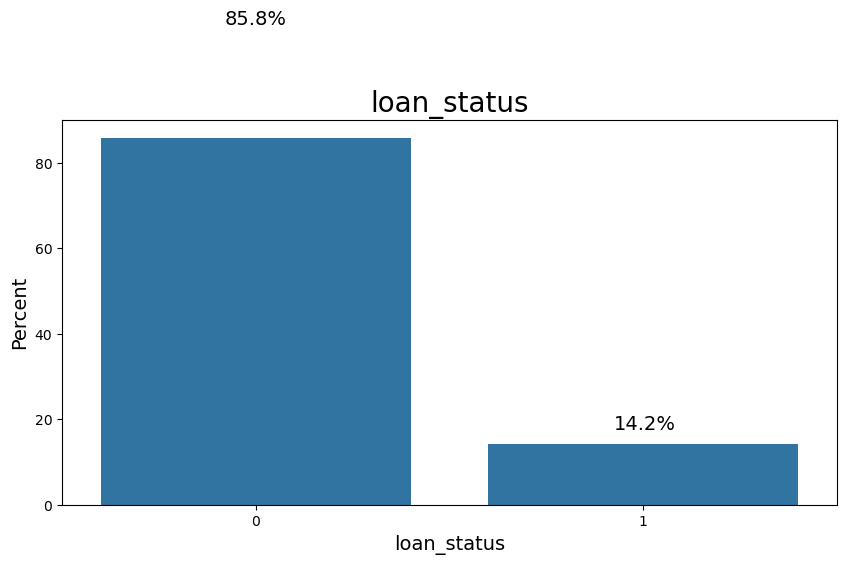

In [11]:
norm_target = (data['loan_status'].value_counts(
    normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='loan_status', y='percent', data=norm_target)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        textcoords='offset points',
        fontsize=14)

plt.title('loan_status', fontsize=20)
plt.xlabel('loan_status', fontsize=14)
plt.ylabel('Percent', fontsize=14)

plt.show()

Присутствует дисбаланс классов - претендентов, которые получили отказ в выдаче кредита в 5,6 раз больше.

Для frontend части сохраняем файл с уникальными значениями

In [12]:
def save_unique_train_data(
    data: pd.DataFrame, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns= [target_column], axis=1, errors="ignore"
    )
    
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [13]:
save_unique_train_data(
    data=data,
    target_column=preproc["target_column"],
    unique_values_path=preproc["unique_values_path"],
)

Меняем необходимые значения и типы данных в датасете, удаляем ненужные столбцы

In [14]:
dict_change_columns = preproc['map_change_columns']
change_type_columns = preproc['change_type_columns']

In [15]:
def replace_values(data: pd.DataFrame, map_change_columns: dict) -> pd.DataFrame:
    """
    Замена значений в датасете
    :param data: датасет
    :param map_change_columns: словарь с признаками и значениями
    :return: датасет
    """
    return data.replace(map_change_columns)

In [16]:
data = replace_values(data=data, map_change_columns=dict_change_columns)
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,0,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,0,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,0,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,0,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,0,3,0


In [17]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return:
    """
    return data.astype(change_type_columns, errors="raise")

In [18]:
data = transform_types(data=data, change_type_columns=change_type_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58642 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          58642 non-null  int64   
 1   person_age                  58642 non-null  int64   
 2   person_income               58642 non-null  int64   
 3   person_home_ownership       58642 non-null  object  
 4   person_emp_length           58642 non-null  float64 
 5   loan_intent                 58642 non-null  object  
 6   loan_grade                  58642 non-null  object  
 7   loan_amnt                   58642 non-null  int64   
 8   loan_int_rate               58642 non-null  float64 
 9   loan_percent_income         58642 non-null  float64 
 10  cb_person_default_on_file   58642 non-null  int64   
 11  cb_person_cred_hist_length  58642 non-null  int64   
 12  loan_status                 58642 non-null  category
dtypes: category(1), float

Заполняем пропуски в данных

In [19]:
def filling_nan(data: pd.DataFrame) -> pd.DataFrame:
    """
    Заполнение пропущенных значений в датасете
    :param data: датасет
    :return: датасет с заполненнными пропусками
    """
    # Создаем список из колонок с пропущенными значениями
    nan_col_list = data.isna().sum().to_frame(name="nans").query("nans > 0").index
    
    # Заполняем пропуски в колонках: столбцы с числовыми данными заполняем медианой, с категориальными модой
    for col in nan_col_list:
        if data[col].dtype == int or data[col].dtype == float:
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)
    
    return data

In [20]:
data = filling_nan(data=data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58642 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          58642 non-null  int64   
 1   person_age                  58642 non-null  int64   
 2   person_income               58642 non-null  int64   
 3   person_home_ownership       58642 non-null  object  
 4   person_emp_length           58642 non-null  float64 
 5   loan_intent                 58642 non-null  object  
 6   loan_grade                  58642 non-null  object  
 7   loan_amnt                   58642 non-null  int64   
 8   loan_int_rate               58642 non-null  float64 
 9   loan_percent_income         58642 non-null  float64 
 10  cb_person_default_on_file   58642 non-null  int64   
 11  cb_person_cred_hist_length  58642 non-null  int64   
 12  loan_status                 58642 non-null  category
dtypes: category(1), float

# Выводы
- Возраст претендентов на кредит от 20 до 84 лет, при этом большему числу претендентов до 30 лет;
- Средний стаж претендентов - около 5-ти лет, средний годовой доход - 64 000 USD;
- Большая часть заемщиков арендуют жилье;
- Чаще всего кредит запрашивают на образовательные цели, средний размер кредита 9 200 USD, процентная ставка 11%;

# Гипотезы

In [21]:
def barplot_group(data: pd.DataFrame, col_main: str, col_group: str, title: str) -> None:
    """
     Функция для отрисовки барплотов
    """
    plt.figure(figsize=(15, 7))

    data_group = (data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
        'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_group,
                     data=data_group,
                     palette='Paired',
                     saturation=.5
                    )

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 10),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=14)

    plt.title(title, fontsize=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.legend(fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

## Гипотеза №1.
### Людям, не имеющим собственного жилья чаще отказываот в кредите.

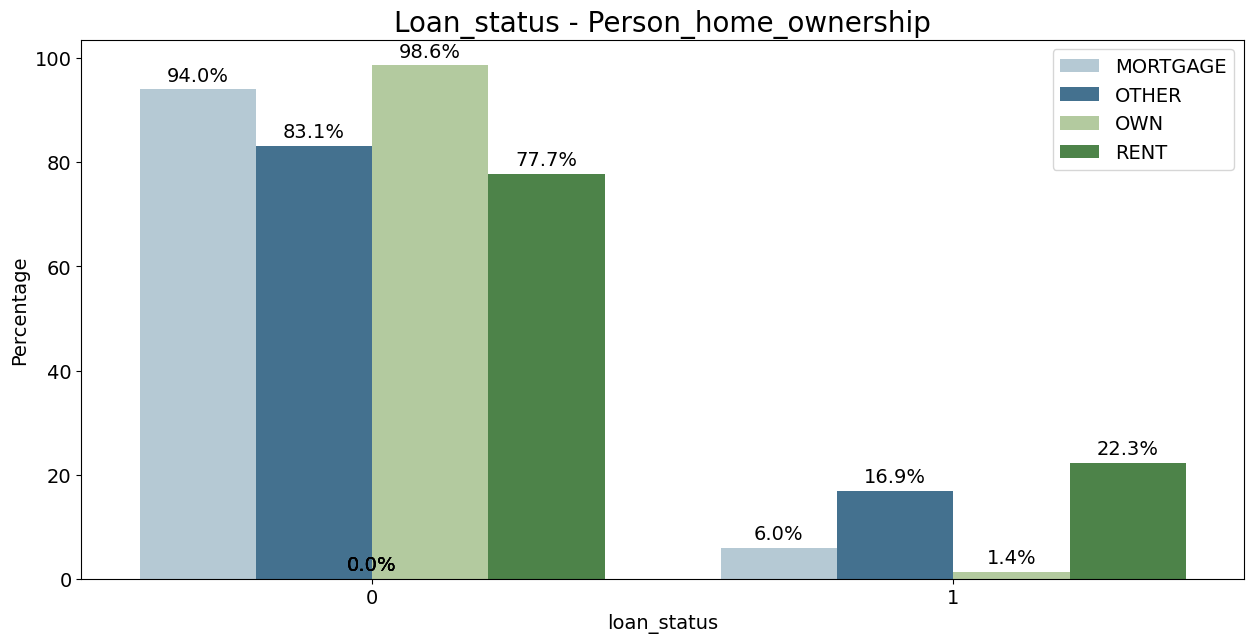

In [22]:
barplot_group(data, 'loan_status', 'person_home_ownership', title= 'Loan_status - Person_home_ownership')

Гипотеза не подтвердилась, людям арендующим жилье наоборот чаще других одобряют кредиты.

## Гипотеза №2.
### Есть прямая связь между целью кредита и процентом отказа - чаще отказывают в выдаче кредитов на какие-либо определенные цели.

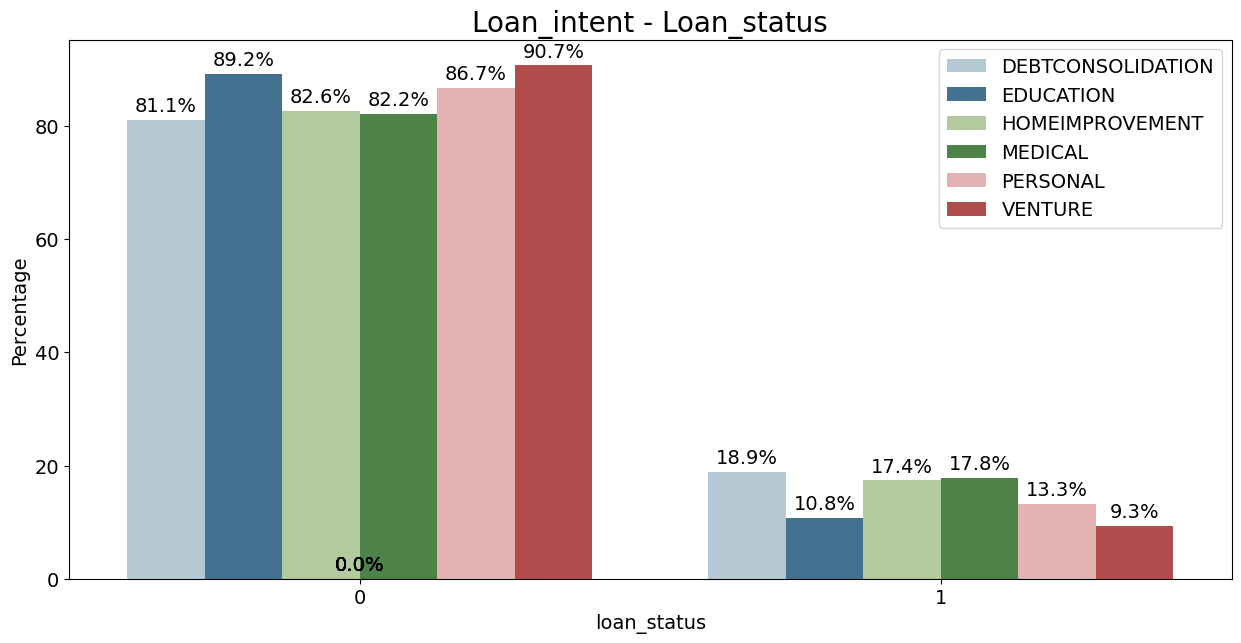

In [23]:
barplot_group(data, "loan_status", "loan_intent", title="Loan_intent - Loan_status")

Гипотеза подтвердилась, чаще отказывают в кредитах на венчурные услуги и образование, реже всего на рефинансирование кредитов.

## Гипотеза №3.
### Чем выше степень риска кредита, тем чаще отказы в выдаче.

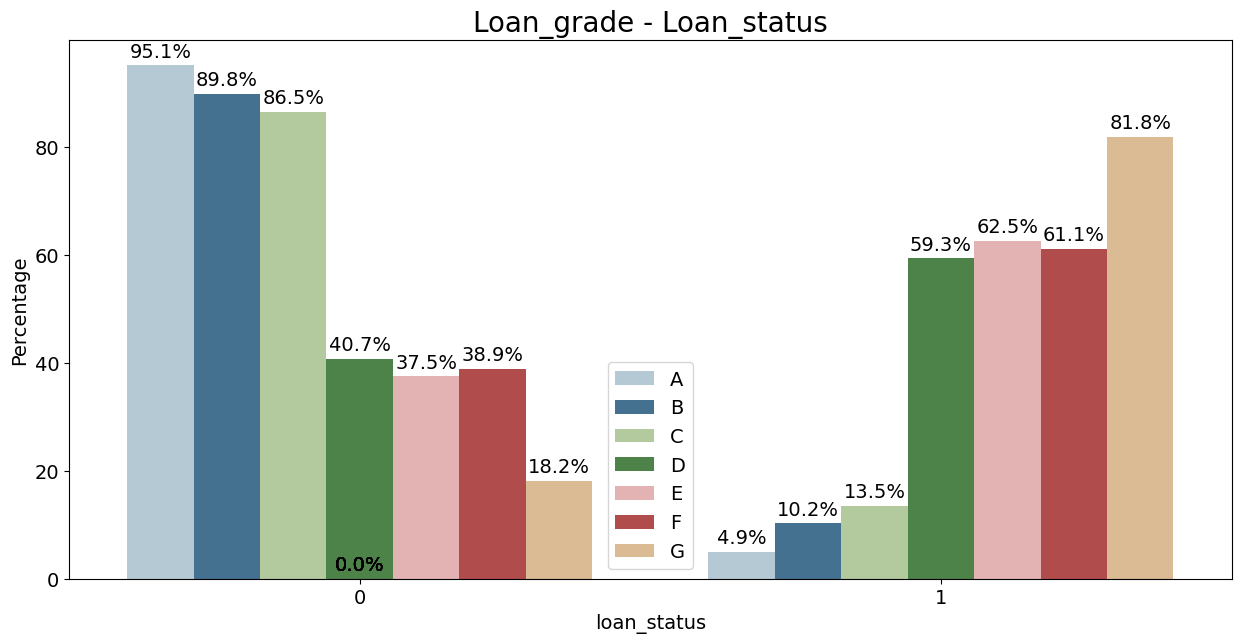

In [24]:
barplot_group(data, "loan_status", "loan_grade", title="Loan_grade - Loan_status")

Гипотеза подтверждается при условии, что А - самая высокая степень риска, а G - самая низкая соответвенно. 

## Гипотеза №4.
### Людям с плохой кредитной историей чаще не выдают кредиты.

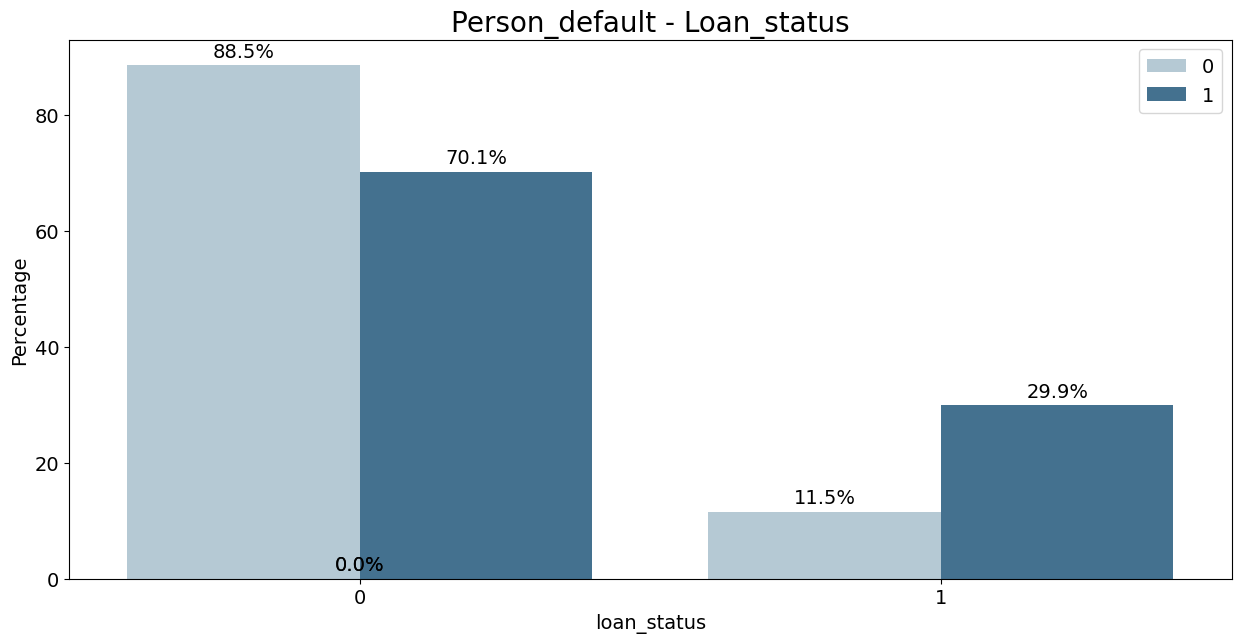

In [25]:
barplot_group(data, "loan_status", "cb_person_default_on_file", title="Person_default - Loan_status")

Гипотеза не подтвердилась, заемщикам с историей неисполнения обязательств кредиты одобряют чаще.

In [26]:
def boxplot_group(data: pd.DataFrame, col_x: str, col_y: str, hue: str,
                  title: str) -> None:
    '''
    Функция для отрисовки боксплотов
    '''
    plt.figure(figsize=(20, 10))

    sns.boxplot(data=data, x=col_x, y=col_y, hue=hue, palette='Paired', saturation=.5)

    plt.title(title, fontsize=30)
    plt.ylabel(col_y, fontsize=20)
    plt.xlabel(col_x, fontsize=20)
    plt.legend(loc='upper right', fontsize=20)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

## Гипотеза №5.
### Чем больше процент дохода, выделяемого на оплату кредита, тем реже выдают кредит.

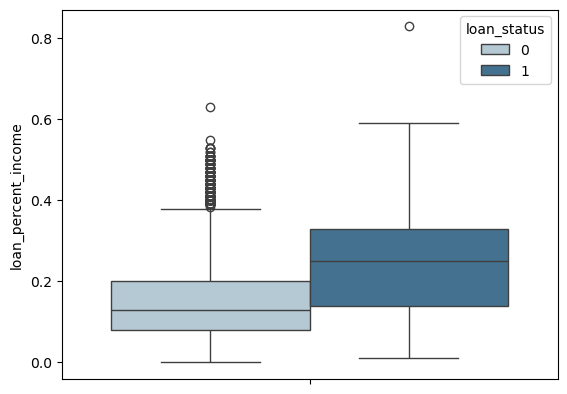

In [27]:
sns.boxplot(data=data, y='loan_percent_income', hue='loan_status', palette='Paired', saturation=.5)
plt.show()

Гипотеза не подтвердилась.

## Гипотеза №6.
### Чем больше сумма кредита, тем чаще отказывают в выдаче.

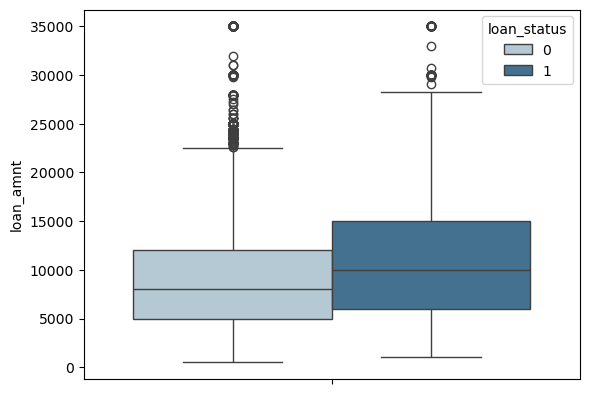

In [28]:
sns.boxplot(data=data, y='loan_amnt', hue='loan_status', palette='Paired', saturation=.5)

plt.show()

Гипотеза не подтвердилась, четкой взаимосвязи нет.

## Гипотеза №7.
### Молодым людям, арендующим жилье чаще отказывают в выдаче кредита.

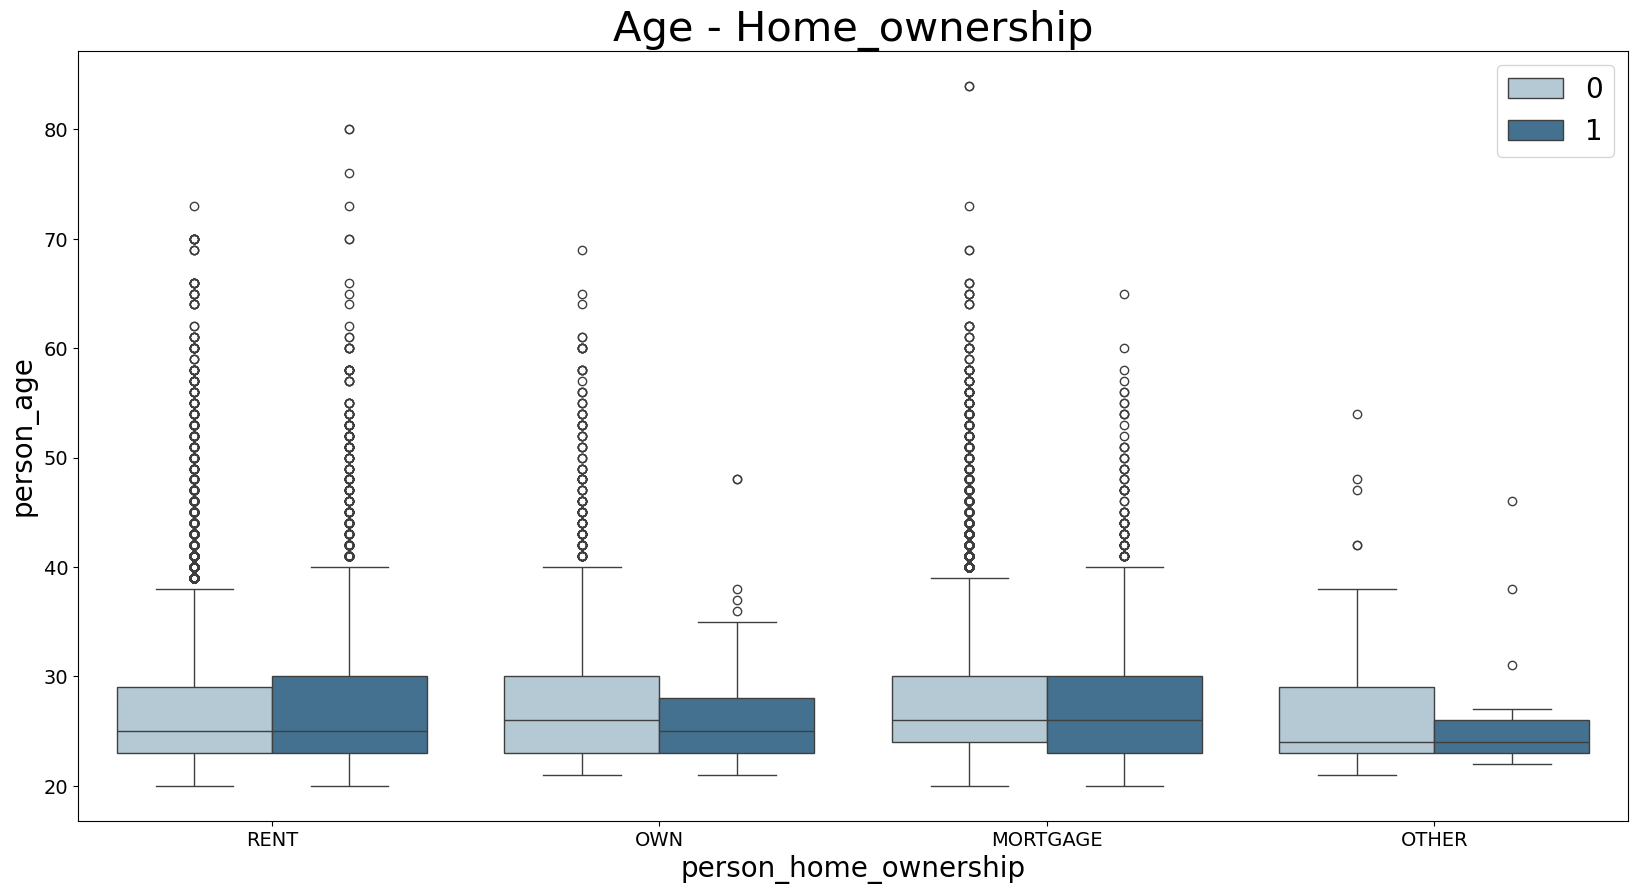

In [29]:
boxplot_group(data, 'person_home_ownership', 'person_age', 'loan_status', 'Age - Home_ownership')

Гипотеза не подтвердилась, связь возраст - статус домовладельца - статус выдачи кредита отсутствует.

## Гипотеза №8.
### Чем выше степень риска кредита, тем выше процент под который выдают кредит.

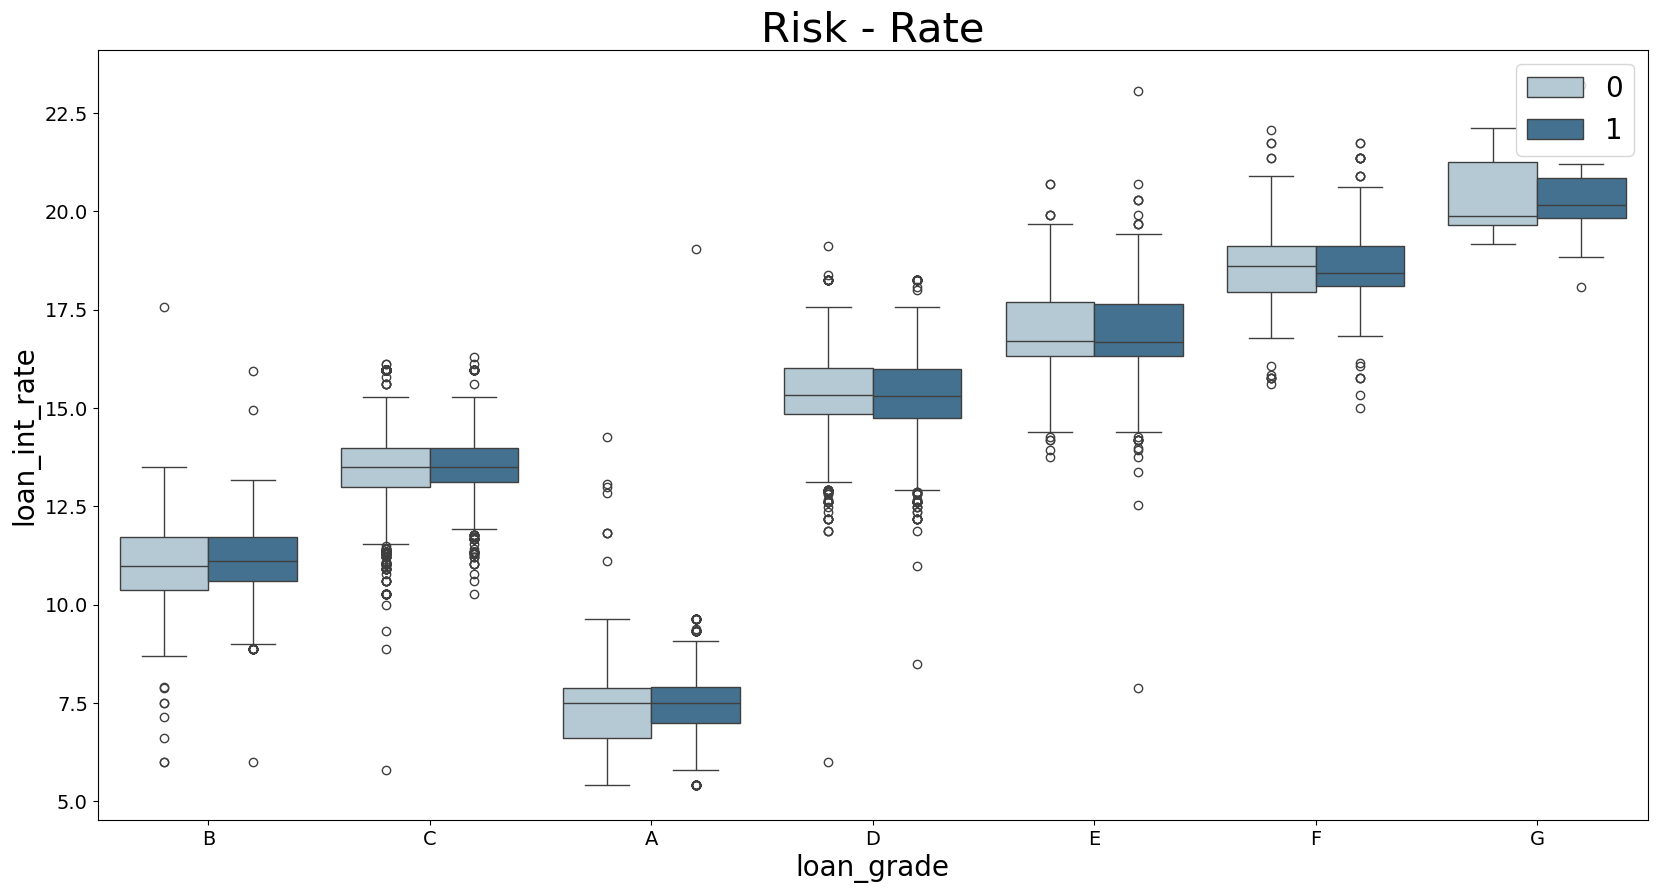

In [30]:
boxplot_group(data, 'loan_grade', 'loan_int_rate', 'loan_status', 'Risk - Rate')

Гипотеза подтвердилась.

# Feature engineering

Визуализируем корреляционную матрицу числовых признаков и высокоскоррелированные признаки удаляем.

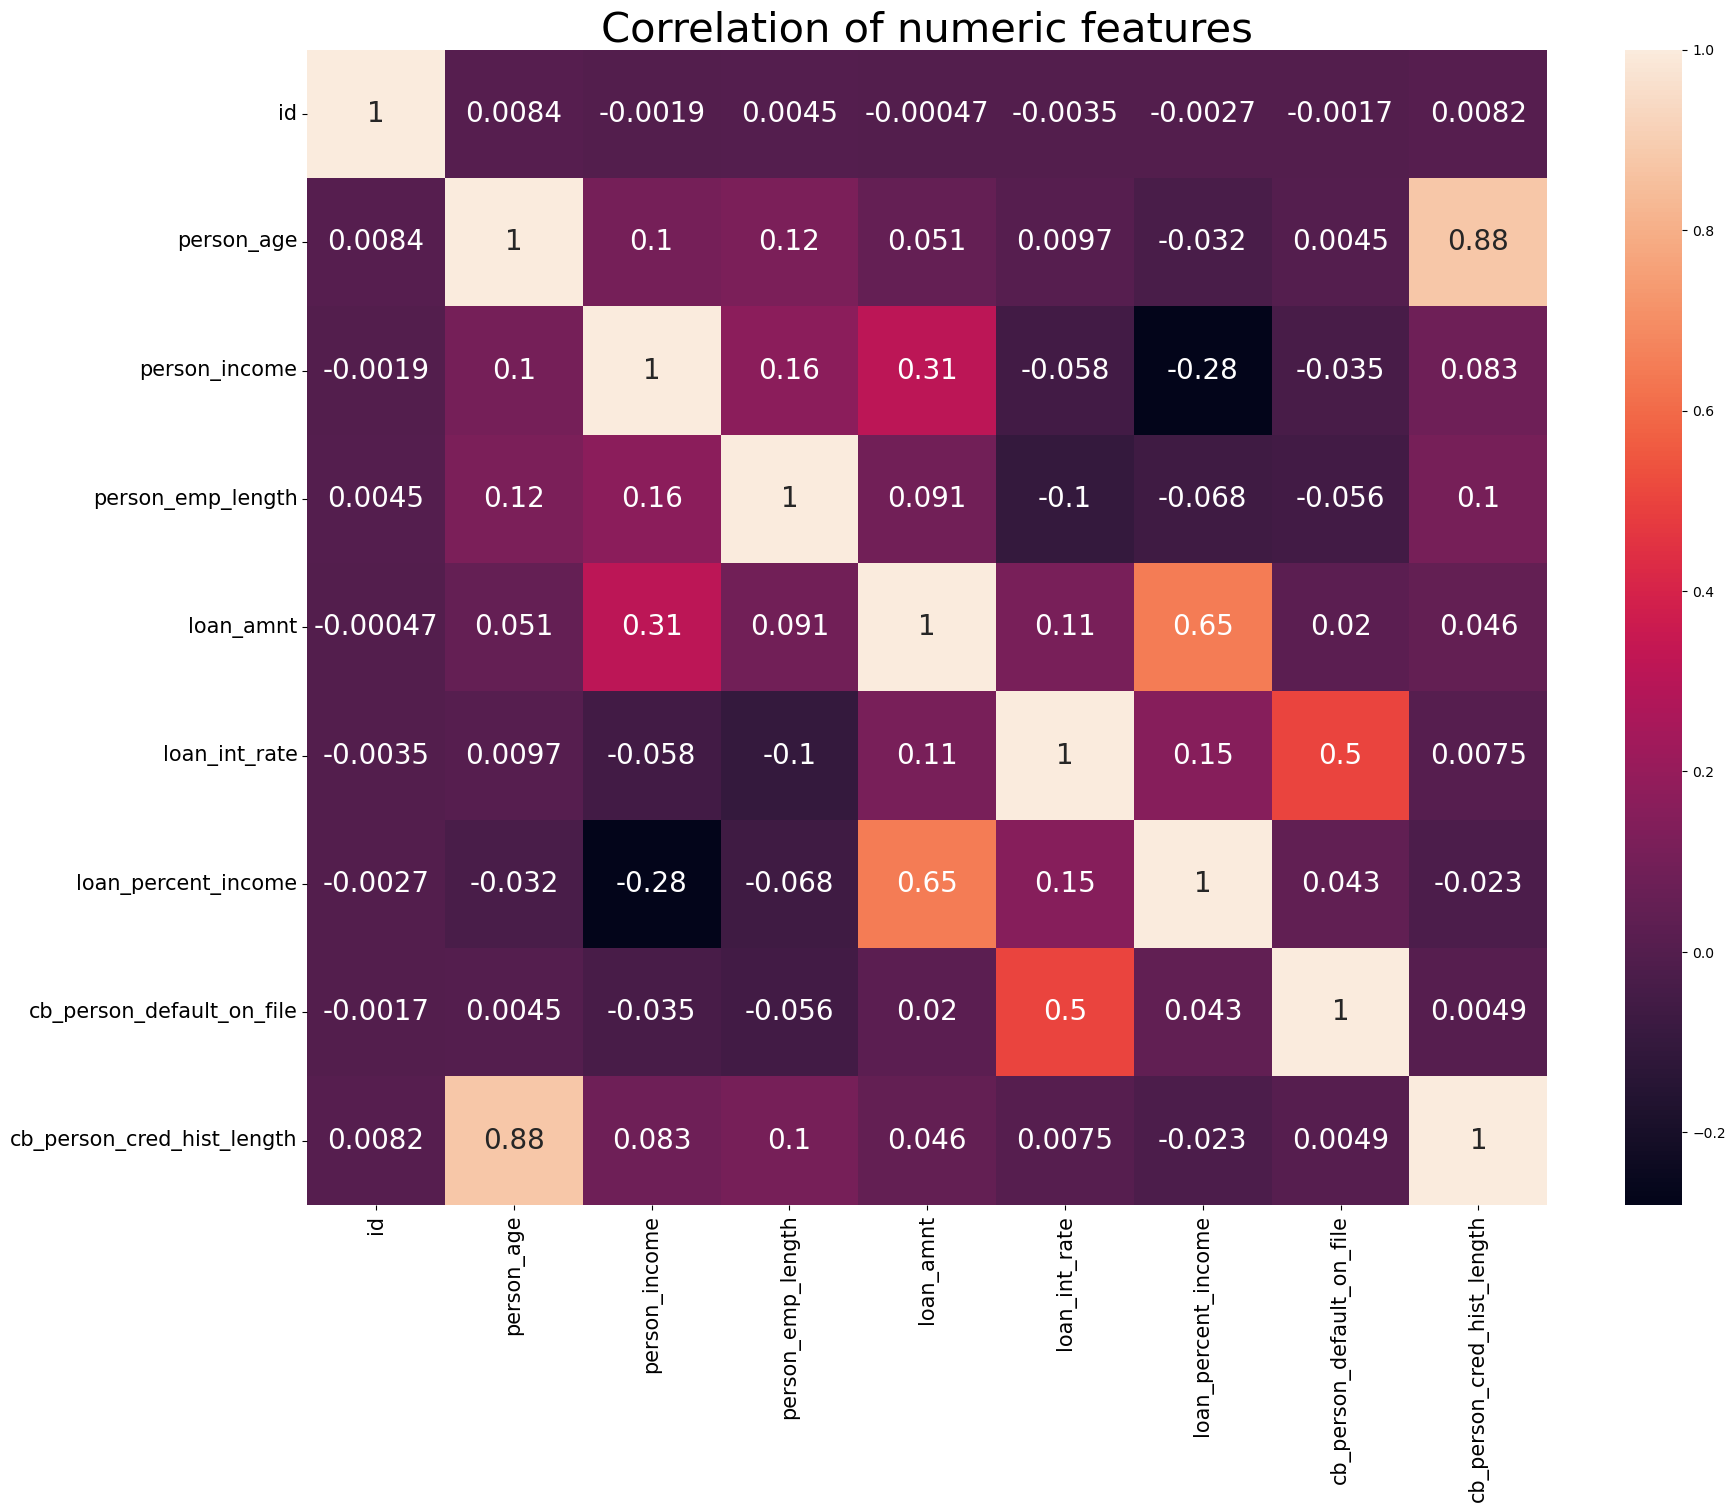

In [31]:
correlation_matrix = data.select_dtypes(include=['int','float']).corr()

plt.figure(figsize=(20, 15))

sns.heatmap(correlation_matrix, annot = True, annot_kws={"fontsize":20})

plt.title('Correlation of numeric features', fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

Высокоскоррелированные признаки (>0,95) отсутствуют

Далее добавляем столбцы с бинами для всех числовых признаков

In [32]:
def get_bins(data: (int, float), first_val: (int, float),
             second_val: (int, float)) -> str:
    """
    Генерация столбцов с бинами для различных числовых признаков
    :param data: датасет
    :param first_val: первый порог значения для разбиения на бины
    :param second_val: второй порог значения для разбиения на бины
    :return: датасет
    """
    assert isinstance(data, (int, float)), "Проблема с типом данных в признаке"
    result = ("small" if data <= first_val else
              "medium" if first_val < data <= second_val else "large")
    return result

In [33]:
preproc["map_bins_columns"]

{'person_age': [35, 55],
 'person_income': [40000, 80000],
 'person_emp_length': [3, 10],
 'loan_amnt': [7000, 10000],
 'loan_int_rate': [8, 15],
 'loan_percent_income': [0.1, 0.3],
 'cb_person_cred_hist_length': [5, 10]}

In [34]:
for key in preproc["map_bins_columns"].keys():
    data[f"{key}_bins"] = data[key].apply(lambda x: get_bins(
        x,
        first_val=preproc["map_bins_columns"][key][0],
        second_val=preproc["map_bins_columns"][key][1],
    ))

In [35]:
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_age_bins,person_income_bins,person_emp_length_bins,loan_amnt_bins,loan_int_rate_bins,loan_percent_income_bins,cb_person_cred_hist_length_bins
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,0,14,0,medium,small,small,small,medium,medium,large
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,0,2,0,small,medium,medium,small,medium,small,small
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,0,10,0,small,small,medium,small,medium,medium,medium
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,0,5,0,small,medium,large,large,medium,medium,small
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,0,3,0,small,medium,small,small,small,small,small


В качестве модели будем использовать LGBM. Для этого необходимо все колонки типа object перевести в category

In [36]:
dict_category = {
    key: "category"
    for key in data.select_dtypes(["object"]).columns
}
data = transform_types(data=data, change_type_columns=dict_category)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58642 entries, 0 to 58644
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   id                               58642 non-null  int64   
 1   person_age                       58642 non-null  int64   
 2   person_income                    58642 non-null  int64   
 3   person_home_ownership            58642 non-null  category
 4   person_emp_length                58642 non-null  float64 
 5   loan_intent                      58642 non-null  category
 6   loan_grade                       58642 non-null  category
 7   loan_amnt                        58642 non-null  int64   
 8   loan_int_rate                    58642 non-null  float64 
 9   loan_percent_income              58642 non-null  float64 
 10  cb_person_default_on_file        58642 non-null  int64   
 11  cb_person_cred_hist_length       58642 non-null  int64   
 12  loan_stat

# Training

## Baseline

In [90]:
X = data.drop(columns=[preproc['drop_columns'][0], training['target_column']],
              axis=1)
y = data[training['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=preproc['test_size'],
    random_state=preproc['random_state'])

In [91]:
lgb = LGBMClassifier(random_state=training['random_state'], class_weight='balanced', verbose=0)
lgb.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=10, verbose=0)

In [92]:
def get_metrics(y_test: np.array, y_pred: np.array, y_score: np.array, name: str) -> pd.DataFrame():
    """
    Генерация таблицы с метриками для задачи классификации
    """
    df_metrics = pd.DataFrame()

    df_metrics['Model'] = [name]
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [93]:
metrics = get_metrics(y_test, 
                      y_pred=lgb.predict(X_test),
                      y_score=lgb.predict_proba(X_test),
                      name='LGBM_Baseline')
metrics

,Model,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_Baseline,0.95753,0.710752,0.843114,0.771296,0.219151


In [94]:
def check_overfitting(model: str, X_train: pd.DataFrame, y_train: np.array, X_test: pd.DataFrame, y_test:np.array):
    """
    Проверка на overfitting для классификации
    """
    y_proba_train = model.predict_proba(X_train)
    y_proba_test = model.predict_proba(X_test)
    value_train = roc_auc_score(y_train, y_proba_train[:, 1])
    value_test = roc_auc_score(y_test, y_proba_test[:, 1])

    print(f'{roc_auc_score.__name__} train: %.3f' % value_train)
    print(f'{roc_auc_score.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [95]:
check_overfitting(lgb, X_train, y_train, X_test, y_test)

roc_auc_score train: 0.976
roc_auc_score test: 0.958
delta = 2.0 %


## Tuning

Выбираем оптимальное количество деревьев

In [96]:
for num in [100, 200, 300]:
    lgb = LGBMClassifier(class_weight='balanced',
                         random_state=training['random_state'],
                         n_estimators=num,
                         verbose=0)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_test)
    y_pred_proba = lgb.predict_proba(X_test)

    result = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"estimators_num = {num}, roc_auc={result}")

estimators_num = 100, roc_auc=0.9575303910520743
estimators_num = 200, roc_auc=0.9569495961849044
estimators_num = 300, roc_auc=0.956299688127473


In [97]:
def objective(trial, X, y, N_FOLDS, RANDOM_STATE):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "random_state": trial.suggest_categorical("random_state", [RANDOM_STATE]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 4, 15, step=1),
        # регуляризация
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 100),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 100),
        "min_split_gain": trial.suggest_int("min_gain_to_split", 0, 20),
        # доля объектов при обучении в дереве
        "subsample": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "subsample_freq": trial.suggest_categorical("bagging_freq", [1]),
        # доля признаков при обучении в дереве
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "class_weight": trial.suggest_categorical("class_weight", ['balanced'])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True,
                         random_state=RANDOM_STATE)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")

        model = LGBMClassifier(**param_grid, verbose=-1)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  callbacks=[pruning_callback])
        
        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

In [98]:
study = optuna.create_study(direction="maximize", study_name="LGB")
func = lambda trial: objective(trial, X_train, y_train, training['n_folds'], training['random_state'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=training['n_trials'], show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [99]:
print(f"\tBest value (AUC): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.94948
	Best params:
		n_estimators: 100
		random_state: 10
		learning_rate: 0.17359535045024094
		num_leaves: 200
		max_depth: 5
		lambda_l1: 17
		lambda_l2: 5
		min_gain_to_split: 2
		bagging_fraction: 0.6055818953290819
		bagging_freq: 1
		colsample_bytree: 0.879943069244961
		class_weight: balanced


In [100]:
optuna.visualization.plot_param_importances(study)

In [101]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [102]:
study.best_params

{'n_estimators': 100,
 'random_state': 10,
 'learning_rate': 0.17359535045024094,
 'num_leaves': 200,
 'max_depth': 5,
 'lambda_l1': 17,
 'lambda_l2': 5,
 'min_gain_to_split': 2,
 'bagging_fraction': 0.6055818953290819,
 'bagging_freq': 1,
 'colsample_bytree': 0.879943069244961,
 'class_weight': 'balanced'}

## Train with best params

In [103]:
clf = LGBMClassifier(**study.best_params, verbose=-1)
clf.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.6055818953290819, bagging_freq=1,
               class_weight='balanced', colsample_bytree=0.879943069244961,
               lambda_l1=17, lambda_l2=5, learning_rate=0.17359535045024094,
               max_depth=5, min_gain_to_split=2, num_leaves=200,
               random_state=10, verbose=-1)

In [104]:
metrics = pd.concat([metrics, get_metrics(y_test, 
                                        y_pred=clf.predict(X_test),
                                        y_score=clf.predict_proba(X_test),
                                        name='LGBM_Tune')])
metrics

,Model,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_Baseline,0.957530,0.710752,0.843114,0.771296,0.219151
0,LGBM_Tune,0.953747,0.670034,0.834132,0.743132,0.240074


In [105]:
check_overfitting(clf, X_train, y_train, X_test, y_test)

roc_auc_score train: 0.960
roc_auc_score test: 0.954
delta = 0.6 %


In [106]:
def plot_confusion_matrix(y_true, X, ax, model=None, prediction=None):
    """
    Визуализация ConfusionMatrix
    """
    if prediction is None:
        prediction = model.predict(X_test)
        
    labels = list(set(prediction))
    cm_ovr = confusion_matrix(y_test, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)

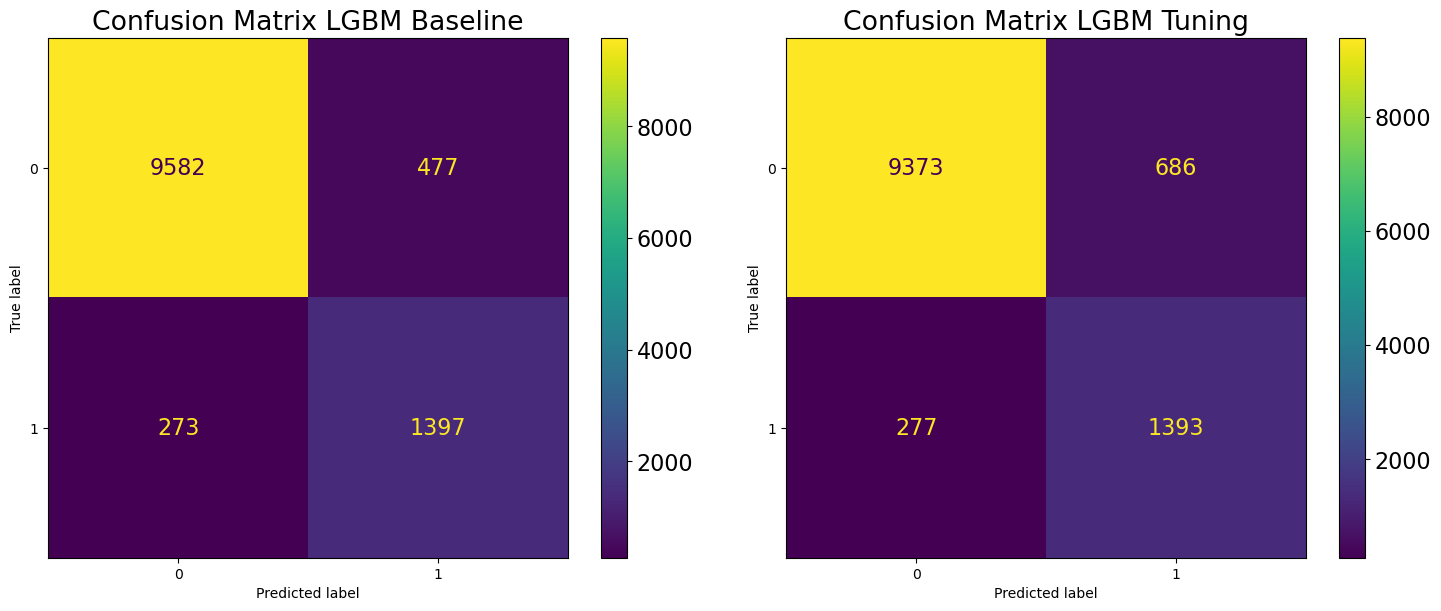

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=lgb, y_true=y_test, X=X_test, ax=ax[0])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=clf, y_true=y_test, X=X_test, ax=ax[1])

ax[0].set_title('Confusion Matrix LGBM Baseline')
ax[1].set_title('Confusion Matrix LGBM Tuning')
plt.tight_layout()  
plt.show()

Для текущей задачи наиболее важным будем считать кол-во ошибок первого рода (FP), т.е. **модель предсказала, что человеку можно выдать кредит, при том, что делать это было нельзя.**

После тюнинга модели метрики упали незначительно, переобучение стало намного меньше. При этом ошибок первого рода стало намного (почти в 2 раза) больше.

# Stacking

В качестве модели стекинга будем использовать **LGBM baseline + LGBM Tune + Catboost tune - meta LogisticRegression**

Обучаем модель CatBoost

In [108]:
# Формируем список из колонок с категориальными данными для подачи в Catboost
cat_features = X_train.select_dtypes('category').columns.tolist()

# Выбираем оптимальное количество деревьев
for num in [100, 200, 300]:
    cat = CatBoostClassifier(random_state=training['random_state'],
                             cat_features=cat_features,
                             n_estimators=num,
                             verbose=0)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)
    y_pred_proba = cat.predict_proba(X_test)

    result = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"estimators_num = {num}, roc_auc={result}")

estimators_num = 100, roc_auc=0.9508369779974795
estimators_num = 200, roc_auc=0.9553253766847457
estimators_num = 300, roc_auc=0.9554549713576128


In [109]:
# Подбираем гиперпараметры
grid = {
    "n_estimators": [300],
    "learning_rate": np.logspace(-3, -1, 3),
    "max_depth": list(range(4, 15)),
    "l2_leaf_reg": np.logspace(-5, 2, 5),
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS", "No"],
    "border_count": [128, 254],
    "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"],
    "random_state": [training['random_state']]}


model = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           cat_features=cat_features,
                           silent=True)

grid_search_result = model.randomized_search(grid,
                                             X=X_train,
                                             y=y_train,
                                             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training has stopped (degenerate solution on iteration 166, probably too small l2-regularization, try to increase it)



bestTest = 0.9299265458
bestIteration = 151

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9299265	best: 0.9299265 (0)	total: 51.3s	remaining: 7m 41s

bestTest = 0.9017332031
bestIteration = 229

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9017332	best: 0.9299265 (0)	total: 1m 8s	remaining: 4m 32s

bestTest = 0.9205868448
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9205868	best: 0.9299265 (0)	total: 2m 13s	remaining: 5m 12s

bestTest = 0.9160223491
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9160223	best: 0.9299265 (0)	total: 2m 47s	remaining: 4m 11

In [110]:
grid_search_result['params']

{'border_count': 128,
 'random_seed': 10,
 'depth': 6,
 'iterations': 300,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.03162277660168379,
 'grow_policy': 'Lossguide',
 'bootstrap_type': 'MVS'}

In [111]:
best_params_cat = grid_search_result['params']

In [112]:
cat_grid = CatBoostClassifier(**best_params_cat,
                              cat_features=cat_features,
                              loss_function='Logloss',
                              eval_metric='AUC')
cat_grid.fit(X_train,
             y_train,
             cat_features=cat_features,
             verbose=False)

In [113]:
metrics = pd.concat([metrics, get_metrics(y_test, 
                                        y_pred=cat_grid.predict(X_test),
                                        y_score=cat_grid.predict_proba(X_test),
                                        name='CatBoost_Tune')])
metrics

,Model,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_Baseline,0.957530,0.710752,0.843114,0.771296,0.219151
0,LGBM_Tune,0.953747,0.670034,0.834132,0.743132,0.240074
0,CatBoost_Tune,0.955760,0.926606,0.725749,0.813969,0.147923


In [114]:
check_overfitting(cat_grid, X_train, y_train, X_test, y_test)

roc_auc_score train: 0.978
roc_auc_score test: 0.956
delta = 2.3 %


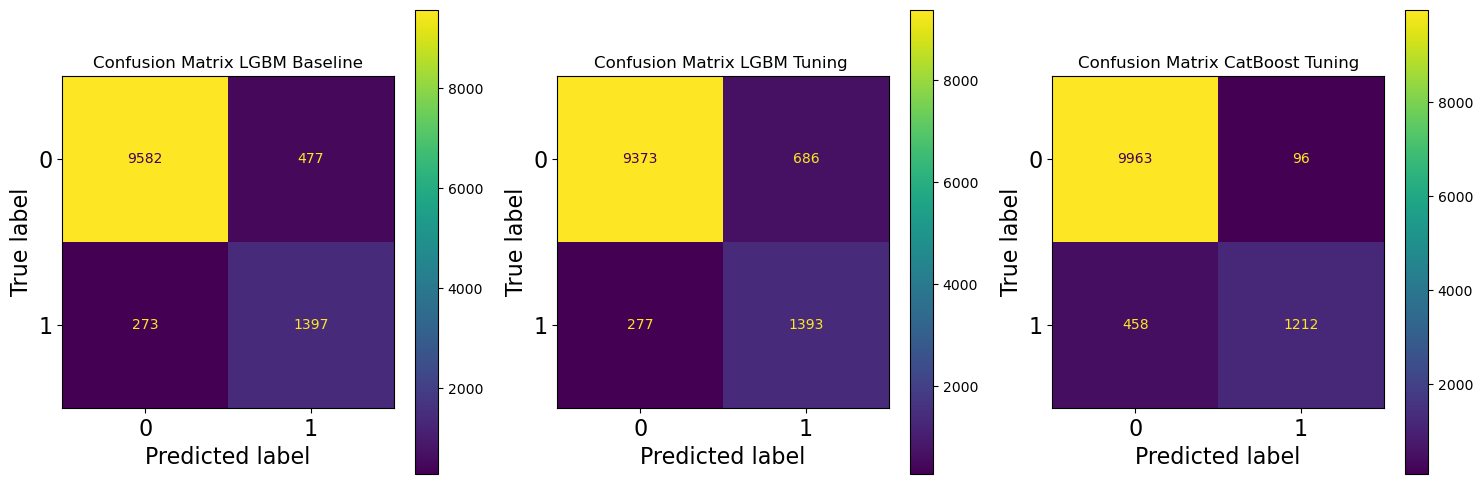

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plt.rcParams.update({'font.size': 10})
plot_confusion_matrix(model=lgb, y_true=y_test, X=X_test, ax=ax[0])
plt.rcParams.update({'font.size': 10})
plot_confusion_matrix(model=clf, y_true=y_test, X=X_test, ax=ax[1])
plt.rcParams.update({'font.size': 10})
plot_confusion_matrix(model=cat_grid, y_true=y_test, X=X_test, ax=ax[2])

ax[0].set_title('Confusion Matrix LGBM Baseline')
ax[1].set_title('Confusion Matrix LGBM Tuning ')
ax[2].set_title('Confusion Matrix CatBoost Tuning')
plt.tight_layout()  
plt.show()

Из полученных метрик видно, что лучше всего отработала модель CatBoost: метрики улучшились, а количество FP уменьшилось в 4 раза по сравнению с LGBM Baseline и в 8 раз по сравнению с LGMB Tune.

In [116]:
# Строим модель стекинга
clb_lgb = CalibratedClassifierCV(base_estimator=lgb,
    method='isotonic',
    cv=3)
clb_clf = CalibratedClassifierCV(base_estimator=clf,
    method='isotonic',
    cv=3)
clb_cat = CalibratedClassifierCV(base_estimator=cat_grid,
    method='isotonic',
    cv=3)

estimators = [('lgb_base', clb_lgb), ('lgb_tune', clb_clf), ('cat_tune', clb_cat)]

stf_cv = StratifiedKFold(n_splits=5)
meta = StackingClassifier(
    estimators=estimators,
    stack_method='predict_proba',
    cv=stf_cv,
    final_estimator=LogisticRegression(random_state=preproc['random_state']))

In [117]:
meta.fit(X_train, y_train)

0:	total: 186ms	remaining: 55.7s
1:	total: 362ms	remaining: 53.9s
2:	total: 531ms	remaining: 52.6s
3:	total: 715ms	remaining: 52.9s
4:	total: 889ms	remaining: 52.5s
5:	total: 1.06s	remaining: 52s
6:	total: 1.23s	remaining: 51.6s
7:	total: 1.42s	remaining: 51.9s
8:	total: 1.61s	remaining: 52.1s
9:	total: 1.8s	remaining: 52.1s
10:	total: 2s	remaining: 52.5s
11:	total: 2.18s	remaining: 52.3s
12:	total: 2.38s	remaining: 52.5s
13:	total: 2.56s	remaining: 52.2s
14:	total: 2.75s	remaining: 52.4s
15:	total: 2.92s	remaining: 51.9s
16:	total: 3.16s	remaining: 52.6s
17:	total: 3.37s	remaining: 52.8s
18:	total: 3.65s	remaining: 53.9s
19:	total: 3.84s	remaining: 53.8s
20:	total: 4.07s	remaining: 54s
21:	total: 4.29s	remaining: 54.2s
22:	total: 4.5s	remaining: 54.2s
23:	total: 4.73s	remaining: 54.4s
24:	total: 4.94s	remaining: 54.3s
25:	total: 5.14s	remaining: 54.2s
26:	total: 5.33s	remaining: 53.9s
27:	total: 5.54s	remaining: 53.8s
28:	total: 5.72s	remaining: 53.4s
29:	total: 5.91s	remaining: 53.2s

241:	total: 47.4s	remaining: 11.4s
242:	total: 47.6s	remaining: 11.2s
243:	total: 47.8s	remaining: 11s
244:	total: 48s	remaining: 10.8s
245:	total: 48.2s	remaining: 10.6s
246:	total: 48.4s	remaining: 10.4s
247:	total: 48.6s	remaining: 10.2s
248:	total: 48.8s	remaining: 9.99s
249:	total: 49s	remaining: 9.79s
250:	total: 49.2s	remaining: 9.61s
251:	total: 49.5s	remaining: 9.42s
252:	total: 49.7s	remaining: 9.23s
253:	total: 49.9s	remaining: 9.03s
254:	total: 50.2s	remaining: 8.86s
255:	total: 50.4s	remaining: 8.66s
256:	total: 50.6s	remaining: 8.46s
257:	total: 50.8s	remaining: 8.27s
258:	total: 51s	remaining: 8.07s
259:	total: 51.2s	remaining: 7.87s
260:	total: 51.4s	remaining: 7.67s
261:	total: 51.6s	remaining: 7.48s
262:	total: 51.8s	remaining: 7.28s
263:	total: 52s	remaining: 7.09s
264:	total: 52.2s	remaining: 6.89s
265:	total: 52.4s	remaining: 6.69s
266:	total: 52.6s	remaining: 6.5s
267:	total: 52.8s	remaining: 6.3s
268:	total: 53s	remaining: 6.11s
269:	total: 53.2s	remaining: 5.91s

182:	total: 37.9s	remaining: 24.2s
183:	total: 38s	remaining: 24s
184:	total: 38.2s	remaining: 23.8s
185:	total: 38.5s	remaining: 23.6s
186:	total: 38.6s	remaining: 23.3s
187:	total: 38.9s	remaining: 23.2s
188:	total: 39.2s	remaining: 23s
189:	total: 39.4s	remaining: 22.8s
190:	total: 39.6s	remaining: 22.6s
191:	total: 39.8s	remaining: 22.4s
192:	total: 40s	remaining: 22.2s
193:	total: 40.3s	remaining: 22s
194:	total: 40.5s	remaining: 21.8s
195:	total: 40.8s	remaining: 21.6s
196:	total: 41s	remaining: 21.4s
197:	total: 41.2s	remaining: 21.2s
198:	total: 41.5s	remaining: 21.1s
199:	total: 41.7s	remaining: 20.8s
200:	total: 42s	remaining: 20.7s
201:	total: 42.3s	remaining: 20.5s
202:	total: 42.5s	remaining: 20.3s
203:	total: 42.7s	remaining: 20.1s
204:	total: 42.9s	remaining: 19.9s
205:	total: 43.1s	remaining: 19.7s
206:	total: 43.3s	remaining: 19.4s
207:	total: 43.5s	remaining: 19.2s
208:	total: 43.7s	remaining: 19s
209:	total: 43.9s	remaining: 18.8s
210:	total: 44.1s	remaining: 18.6s
2

122:	total: 24.7s	remaining: 35.5s
123:	total: 24.9s	remaining: 35.4s
124:	total: 25.1s	remaining: 35.2s
125:	total: 25.4s	remaining: 35.1s
126:	total: 25.8s	remaining: 35.2s
127:	total: 26.3s	remaining: 35.3s
128:	total: 26.6s	remaining: 35.2s
129:	total: 26.8s	remaining: 35.1s
130:	total: 27s	remaining: 34.8s
131:	total: 27.2s	remaining: 34.6s
132:	total: 27.4s	remaining: 34.4s
133:	total: 27.6s	remaining: 34.2s
134:	total: 27.8s	remaining: 34s
135:	total: 28s	remaining: 33.8s
136:	total: 28.2s	remaining: 33.5s
137:	total: 28.4s	remaining: 33.3s
138:	total: 28.6s	remaining: 33.2s
139:	total: 28.8s	remaining: 32.9s
140:	total: 29.2s	remaining: 32.9s
141:	total: 29.5s	remaining: 32.8s
142:	total: 29.7s	remaining: 32.6s
143:	total: 29.9s	remaining: 32.4s
144:	total: 30.1s	remaining: 32.2s
145:	total: 30.3s	remaining: 32s
146:	total: 30.5s	remaining: 31.7s
147:	total: 30.7s	remaining: 31.6s
148:	total: 30.9s	remaining: 31.3s
149:	total: 31.1s	remaining: 31.1s
150:	total: 31.3s	remaining:

63:	total: 11.6s	remaining: 42.9s
64:	total: 11.8s	remaining: 42.6s
65:	total: 12s	remaining: 42.4s
66:	total: 12.1s	remaining: 42.1s
67:	total: 12.3s	remaining: 41.9s
68:	total: 12.5s	remaining: 41.7s
69:	total: 12.7s	remaining: 41.6s
70:	total: 12.8s	remaining: 41.4s
71:	total: 13s	remaining: 41.1s
72:	total: 13.2s	remaining: 41s
73:	total: 13.3s	remaining: 40.7s
74:	total: 13.5s	remaining: 40.5s
75:	total: 13.7s	remaining: 40.3s
76:	total: 13.9s	remaining: 40.2s
77:	total: 14s	remaining: 39.9s
78:	total: 14.2s	remaining: 39.7s
79:	total: 14.4s	remaining: 39.5s
80:	total: 14.5s	remaining: 39.2s
81:	total: 14.7s	remaining: 39s
82:	total: 14.9s	remaining: 38.9s
83:	total: 15s	remaining: 38.7s
84:	total: 15.2s	remaining: 38.5s
85:	total: 15.4s	remaining: 38.3s
86:	total: 15.6s	remaining: 38.1s
87:	total: 15.7s	remaining: 37.9s
88:	total: 15.9s	remaining: 37.6s
89:	total: 16.1s	remaining: 37.5s
90:	total: 16.2s	remaining: 37.2s
91:	total: 16.4s	remaining: 37s
92:	total: 16.5s	remaining: 

2:	total: 630ms	remaining: 1m 2s
3:	total: 851ms	remaining: 1m 2s
4:	total: 1.05s	remaining: 1m 1s
5:	total: 1.25s	remaining: 1m 1s
6:	total: 1.44s	remaining: 1m
7:	total: 1.64s	remaining: 59.8s
8:	total: 1.8s	remaining: 58.4s
9:	total: 1.98s	remaining: 57.4s
10:	total: 2.15s	remaining: 56.4s
11:	total: 2.34s	remaining: 56.2s
12:	total: 2.53s	remaining: 55.9s
13:	total: 2.72s	remaining: 55.5s
14:	total: 2.9s	remaining: 55.2s
15:	total: 3.08s	remaining: 54.8s
16:	total: 3.26s	remaining: 54.2s
17:	total: 3.42s	remaining: 53.6s
18:	total: 3.58s	remaining: 53s
19:	total: 3.75s	remaining: 52.5s
20:	total: 3.91s	remaining: 51.9s
21:	total: 4.08s	remaining: 51.5s
22:	total: 4.23s	remaining: 51s
23:	total: 4.4s	remaining: 50.6s
24:	total: 4.56s	remaining: 50.1s
25:	total: 4.74s	remaining: 50s
26:	total: 4.93s	remaining: 49.8s
27:	total: 5.09s	remaining: 49.5s
28:	total: 5.26s	remaining: 49.2s
29:	total: 5.44s	remaining: 48.9s
30:	total: 5.62s	remaining: 48.7s
31:	total: 5.82s	remaining: 48.7s


243:	total: 47.3s	remaining: 10.8s
244:	total: 47.5s	remaining: 10.7s
245:	total: 47.6s	remaining: 10.5s
246:	total: 47.9s	remaining: 10.3s
247:	total: 48.1s	remaining: 10.1s
248:	total: 48.3s	remaining: 9.89s
249:	total: 48.5s	remaining: 9.71s
250:	total: 48.8s	remaining: 9.52s
251:	total: 49s	remaining: 9.33s
252:	total: 49.2s	remaining: 9.14s
253:	total: 49.4s	remaining: 8.94s
254:	total: 49.6s	remaining: 8.75s
255:	total: 49.8s	remaining: 8.55s
256:	total: 50s	remaining: 8.36s
257:	total: 50.2s	remaining: 8.17s
258:	total: 50.3s	remaining: 7.97s
259:	total: 50.5s	remaining: 7.77s
260:	total: 50.7s	remaining: 7.58s
261:	total: 50.9s	remaining: 7.38s
262:	total: 51.1s	remaining: 7.19s
263:	total: 51.3s	remaining: 6.99s
264:	total: 51.5s	remaining: 6.8s
265:	total: 51.7s	remaining: 6.6s
266:	total: 51.9s	remaining: 6.41s
267:	total: 52s	remaining: 6.21s
268:	total: 52.2s	remaining: 6.02s
269:	total: 52.4s	remaining: 5.82s
270:	total: 52.6s	remaining: 5.63s
271:	total: 52.8s	remaining:

184:	total: 38.2s	remaining: 23.8s
185:	total: 38.6s	remaining: 23.6s
186:	total: 38.9s	remaining: 23.5s
187:	total: 39.2s	remaining: 23.4s
188:	total: 39.5s	remaining: 23.2s
189:	total: 39.7s	remaining: 23s
190:	total: 39.9s	remaining: 22.8s
191:	total: 40.1s	remaining: 22.6s
192:	total: 40.3s	remaining: 22.3s
193:	total: 40.5s	remaining: 22.1s
194:	total: 40.7s	remaining: 21.9s
195:	total: 40.9s	remaining: 21.7s
196:	total: 41.1s	remaining: 21.5s
197:	total: 41.3s	remaining: 21.3s
198:	total: 41.5s	remaining: 21.1s
199:	total: 41.7s	remaining: 20.9s
200:	total: 42s	remaining: 20.7s
201:	total: 42.2s	remaining: 20.5s
202:	total: 42.5s	remaining: 20.3s
203:	total: 42.7s	remaining: 20.1s
204:	total: 42.9s	remaining: 19.9s
205:	total: 43s	remaining: 19.6s
206:	total: 43.2s	remaining: 19.4s
207:	total: 43.4s	remaining: 19.2s
208:	total: 43.6s	remaining: 19s
209:	total: 43.8s	remaining: 18.8s
210:	total: 44s	remaining: 18.6s
211:	total: 44.2s	remaining: 18.3s
212:	total: 44.4s	remaining: 1

125:	total: 23.3s	remaining: 32.2s
126:	total: 23.5s	remaining: 32s
127:	total: 23.7s	remaining: 31.9s
128:	total: 24s	remaining: 31.8s
129:	total: 24.2s	remaining: 31.7s
130:	total: 24.4s	remaining: 31.5s
131:	total: 24.7s	remaining: 31.4s
132:	total: 24.8s	remaining: 31.2s
133:	total: 25s	remaining: 31s
134:	total: 25.2s	remaining: 30.8s
135:	total: 25.4s	remaining: 30.6s
136:	total: 25.6s	remaining: 30.5s
137:	total: 25.8s	remaining: 30.2s
138:	total: 25.9s	remaining: 30.1s
139:	total: 26.2s	remaining: 29.9s
140:	total: 26.4s	remaining: 29.7s
141:	total: 26.6s	remaining: 29.6s
142:	total: 26.8s	remaining: 29.4s
143:	total: 27s	remaining: 29.3s
144:	total: 27.3s	remaining: 29.2s
145:	total: 27.7s	remaining: 29.2s
146:	total: 27.9s	remaining: 29s
147:	total: 28.1s	remaining: 28.9s
148:	total: 28.3s	remaining: 28.7s
149:	total: 28.5s	remaining: 28.5s
150:	total: 28.7s	remaining: 28.4s
151:	total: 28.9s	remaining: 28.2s
152:	total: 29.2s	remaining: 28s
153:	total: 29.4s	remaining: 27.8s

65:	total: 13.3s	remaining: 47.1s
66:	total: 13.5s	remaining: 46.9s
67:	total: 13.7s	remaining: 46.6s
68:	total: 13.9s	remaining: 46.5s
69:	total: 14s	remaining: 46.1s
70:	total: 14.2s	remaining: 45.9s
71:	total: 14.4s	remaining: 45.6s
72:	total: 14.6s	remaining: 45.3s
73:	total: 14.8s	remaining: 45.1s
74:	total: 14.9s	remaining: 44.8s
75:	total: 15.1s	remaining: 44.6s
76:	total: 15.3s	remaining: 44.4s
77:	total: 15.5s	remaining: 44.1s
78:	total: 15.7s	remaining: 43.9s
79:	total: 16.1s	remaining: 44.2s
80:	total: 16.4s	remaining: 44.3s
81:	total: 16.6s	remaining: 44.2s
82:	total: 16.9s	remaining: 44.1s
83:	total: 17.1s	remaining: 43.9s
84:	total: 17.2s	remaining: 43.6s
85:	total: 17.4s	remaining: 43.2s
86:	total: 17.5s	remaining: 43s
87:	total: 17.7s	remaining: 42.7s
88:	total: 17.9s	remaining: 42.5s
89:	total: 18.1s	remaining: 42.3s
90:	total: 18.3s	remaining: 42.1s
91:	total: 18.5s	remaining: 41.9s
92:	total: 18.7s	remaining: 41.6s
93:	total: 18.9s	remaining: 41.4s
94:	total: 19.1s	r

4:	total: 915ms	remaining: 54s
5:	total: 1.1s	remaining: 53.9s
6:	total: 1.31s	remaining: 55.1s
7:	total: 1.49s	remaining: 54.2s
8:	total: 1.71s	remaining: 55.3s
9:	total: 1.9s	remaining: 55s
10:	total: 2.08s	remaining: 54.8s
11:	total: 2.27s	remaining: 54.5s
12:	total: 2.47s	remaining: 54.6s
13:	total: 2.67s	remaining: 54.5s
14:	total: 2.85s	remaining: 54.1s
15:	total: 3.03s	remaining: 53.9s
16:	total: 3.22s	remaining: 53.6s
17:	total: 3.43s	remaining: 53.7s
18:	total: 3.63s	remaining: 53.7s
19:	total: 3.83s	remaining: 53.6s
20:	total: 4s	remaining: 53.2s
21:	total: 4.21s	remaining: 53.3s
22:	total: 4.41s	remaining: 53.2s
23:	total: 4.62s	remaining: 53.2s
24:	total: 4.79s	remaining: 52.7s
25:	total: 4.98s	remaining: 52.5s
26:	total: 5.17s	remaining: 52.3s
27:	total: 5.37s	remaining: 52.2s
28:	total: 5.56s	remaining: 52s
29:	total: 5.76s	remaining: 51.9s
30:	total: 5.94s	remaining: 51.5s
31:	total: 6.14s	remaining: 51.4s
32:	total: 6.3s	remaining: 51s
33:	total: 6.5s	remaining: 50.9s
3

244:	total: 51.1s	remaining: 11.5s
245:	total: 51.3s	remaining: 11.3s
246:	total: 51.4s	remaining: 11s
247:	total: 51.7s	remaining: 10.8s
248:	total: 51.9s	remaining: 10.6s
249:	total: 52.1s	remaining: 10.4s
250:	total: 52.3s	remaining: 10.2s
251:	total: 52.5s	remaining: 9.99s
252:	total: 52.7s	remaining: 9.79s
253:	total: 52.9s	remaining: 9.58s
254:	total: 53.1s	remaining: 9.37s
255:	total: 53.3s	remaining: 9.16s
256:	total: 53.5s	remaining: 8.95s
257:	total: 53.7s	remaining: 8.74s
258:	total: 53.9s	remaining: 8.53s
259:	total: 54.1s	remaining: 8.32s
260:	total: 54.3s	remaining: 8.11s
261:	total: 54.5s	remaining: 7.91s
262:	total: 54.7s	remaining: 7.7s
263:	total: 54.9s	remaining: 7.49s
264:	total: 55.1s	remaining: 7.28s
265:	total: 55.3s	remaining: 7.07s
266:	total: 55.5s	remaining: 6.86s
267:	total: 55.8s	remaining: 6.66s
268:	total: 56s	remaining: 6.45s
269:	total: 56.2s	remaining: 6.25s
270:	total: 56.4s	remaining: 6.04s
271:	total: 56.7s	remaining: 5.83s
272:	total: 56.9s	remaini

184:	total: 41.4s	remaining: 25.8s
185:	total: 41.7s	remaining: 25.6s
186:	total: 41.9s	remaining: 25.3s
187:	total: 42.2s	remaining: 25.1s
188:	total: 42.4s	remaining: 24.9s
189:	total: 42.7s	remaining: 24.7s
190:	total: 42.9s	remaining: 24.5s
191:	total: 43.1s	remaining: 24.2s
192:	total: 43.3s	remaining: 24s
193:	total: 43.5s	remaining: 23.8s
194:	total: 43.8s	remaining: 23.6s
195:	total: 44.1s	remaining: 23.4s
196:	total: 44.4s	remaining: 23.2s
197:	total: 44.6s	remaining: 23s
198:	total: 44.8s	remaining: 22.7s
199:	total: 45s	remaining: 22.5s
200:	total: 45.2s	remaining: 22.3s
201:	total: 45.4s	remaining: 22s
202:	total: 45.6s	remaining: 21.8s
203:	total: 45.8s	remaining: 21.5s
204:	total: 46s	remaining: 21.3s
205:	total: 46.2s	remaining: 21.1s
206:	total: 46.4s	remaining: 20.9s
207:	total: 46.6s	remaining: 20.6s
208:	total: 46.8s	remaining: 20.4s
209:	total: 47s	remaining: 20.1s
210:	total: 47.2s	remaining: 19.9s
211:	total: 47.5s	remaining: 19.7s
212:	total: 47.7s	remaining: 19.

124:	total: 25.3s	remaining: 35.5s
125:	total: 25.5s	remaining: 35.3s
126:	total: 25.7s	remaining: 35s
127:	total: 25.9s	remaining: 34.8s
128:	total: 26.1s	remaining: 34.6s
129:	total: 26.3s	remaining: 34.4s
130:	total: 26.5s	remaining: 34.2s
131:	total: 26.7s	remaining: 34s
132:	total: 26.9s	remaining: 33.8s
133:	total: 27.1s	remaining: 33.6s
134:	total: 27.3s	remaining: 33.4s
135:	total: 27.5s	remaining: 33.1s
136:	total: 27.7s	remaining: 32.9s
137:	total: 27.9s	remaining: 32.7s
138:	total: 28s	remaining: 32.5s
139:	total: 28.2s	remaining: 32.2s
140:	total: 28.4s	remaining: 32.1s
141:	total: 28.6s	remaining: 31.9s
142:	total: 28.8s	remaining: 31.6s
143:	total: 29s	remaining: 31.4s
144:	total: 29.2s	remaining: 31.2s
145:	total: 29.3s	remaining: 31s
146:	total: 29.5s	remaining: 30.7s
147:	total: 29.7s	remaining: 30.5s
148:	total: 29.9s	remaining: 30.3s
149:	total: 30.1s	remaining: 30.1s
150:	total: 30.3s	remaining: 29.9s
151:	total: 30.5s	remaining: 29.7s
152:	total: 30.7s	remaining: 2

63:	total: 16.1s	remaining: 59.5s
64:	total: 16.3s	remaining: 59s
65:	total: 16.6s	remaining: 58.7s
66:	total: 16.7s	remaining: 58.2s
67:	total: 16.9s	remaining: 57.8s
68:	total: 17.1s	remaining: 57.4s
69:	total: 17.3s	remaining: 57s
70:	total: 17.7s	remaining: 57s
71:	total: 17.9s	remaining: 56.5s
72:	total: 18s	remaining: 56.1s
73:	total: 18.2s	remaining: 55.6s
74:	total: 18.4s	remaining: 55.2s
75:	total: 18.6s	remaining: 54.7s
76:	total: 18.7s	remaining: 54.3s
77:	total: 18.9s	remaining: 53.8s
78:	total: 19.1s	remaining: 53.5s
79:	total: 19.3s	remaining: 53s
80:	total: 19.4s	remaining: 52.6s
81:	total: 19.6s	remaining: 52.2s
82:	total: 19.8s	remaining: 51.8s
83:	total: 20s	remaining: 51.4s
84:	total: 20.2s	remaining: 51s
85:	total: 20.4s	remaining: 50.6s
86:	total: 20.5s	remaining: 50.3s
87:	total: 20.7s	remaining: 49.9s
88:	total: 20.9s	remaining: 49.6s
89:	total: 21.1s	remaining: 49.2s
90:	total: 21.3s	remaining: 48.9s
91:	total: 21.5s	remaining: 48.5s
92:	total: 21.7s	remaining: 

2:	total: 572ms	remaining: 56.6s
3:	total: 765ms	remaining: 56.6s
4:	total: 944ms	remaining: 55.7s
5:	total: 1.14s	remaining: 55.9s
6:	total: 1.32s	remaining: 55.3s
7:	total: 1.52s	remaining: 55.4s
8:	total: 1.7s	remaining: 55s
9:	total: 1.89s	remaining: 54.9s
10:	total: 2.08s	remaining: 54.5s
11:	total: 2.29s	remaining: 54.9s
12:	total: 2.5s	remaining: 55.3s
13:	total: 2.75s	remaining: 56.1s
14:	total: 2.96s	remaining: 56.2s
15:	total: 3.19s	remaining: 56.6s
16:	total: 3.39s	remaining: 56.4s
17:	total: 3.6s	remaining: 56.3s
18:	total: 3.82s	remaining: 56.5s
19:	total: 4.02s	remaining: 56.3s
20:	total: 4.2s	remaining: 55.8s
21:	total: 4.62s	remaining: 58.4s
22:	total: 4.99s	remaining: 1m
23:	total: 5.25s	remaining: 1m
24:	total: 5.5s	remaining: 1m
25:	total: 5.75s	remaining: 1m
26:	total: 6s	remaining: 1m
27:	total: 6.23s	remaining: 1m
28:	total: 6.47s	remaining: 1m
29:	total: 6.68s	remaining: 1m
30:	total: 6.86s	remaining: 59.5s
31:	total: 7.07s	remaining: 59.2s
32:	total: 7.25s	remai

243:	total: 54.4s	remaining: 12.5s
244:	total: 54.6s	remaining: 12.3s
245:	total: 54.8s	remaining: 12s
246:	total: 55s	remaining: 11.8s
247:	total: 55.4s	remaining: 11.6s
248:	total: 55.6s	remaining: 11.4s
249:	total: 55.9s	remaining: 11.2s
250:	total: 56s	remaining: 10.9s
251:	total: 56.2s	remaining: 10.7s
252:	total: 56.4s	remaining: 10.5s
253:	total: 56.6s	remaining: 10.3s
254:	total: 56.8s	remaining: 10s
255:	total: 57s	remaining: 9.8s
256:	total: 57.2s	remaining: 9.57s
257:	total: 57.4s	remaining: 9.34s
258:	total: 57.6s	remaining: 9.11s
259:	total: 57.8s	remaining: 8.89s
260:	total: 57.9s	remaining: 8.66s
261:	total: 58.1s	remaining: 8.43s
262:	total: 58.3s	remaining: 8.2s
263:	total: 58.6s	remaining: 7.99s
264:	total: 58.9s	remaining: 7.77s
265:	total: 59.1s	remaining: 7.55s
266:	total: 59.3s	remaining: 7.33s
267:	total: 59.5s	remaining: 7.11s
268:	total: 59.7s	remaining: 6.88s
269:	total: 60s	remaining: 6.66s
270:	total: 1m	remaining: 6.44s
271:	total: 1m	remaining: 6.22s
272:	

184:	total: 42.8s	remaining: 26.6s
185:	total: 43s	remaining: 26.4s
186:	total: 43.2s	remaining: 26.1s
187:	total: 43.4s	remaining: 25.9s
188:	total: 43.6s	remaining: 25.6s
189:	total: 43.9s	remaining: 25.4s
190:	total: 44s	remaining: 25.1s
191:	total: 44.3s	remaining: 24.9s
192:	total: 44.5s	remaining: 24.6s
193:	total: 44.6s	remaining: 24.4s
194:	total: 44.8s	remaining: 24.1s
195:	total: 45.1s	remaining: 23.9s
196:	total: 45.3s	remaining: 23.7s
197:	total: 45.5s	remaining: 23.4s
198:	total: 45.7s	remaining: 23.2s
199:	total: 46s	remaining: 23s
200:	total: 46.2s	remaining: 22.7s
201:	total: 46.4s	remaining: 22.5s
202:	total: 46.6s	remaining: 22.2s
203:	total: 46.8s	remaining: 22s
204:	total: 47s	remaining: 21.8s
205:	total: 47.2s	remaining: 21.5s
206:	total: 47.4s	remaining: 21.3s
207:	total: 47.6s	remaining: 21.1s
208:	total: 47.8s	remaining: 20.8s
209:	total: 48s	remaining: 20.6s
210:	total: 48.2s	remaining: 20.3s
211:	total: 48.4s	remaining: 20.1s
212:	total: 48.6s	remaining: 19.9s

123:	total: 30.5s	remaining: 43.2s
124:	total: 30.6s	remaining: 42.9s
125:	total: 30.8s	remaining: 42.5s
126:	total: 31s	remaining: 42.3s
127:	total: 31.2s	remaining: 42s
128:	total: 31.4s	remaining: 41.6s
129:	total: 31.6s	remaining: 41.3s
130:	total: 31.8s	remaining: 41s
131:	total: 32s	remaining: 40.7s
132:	total: 32.2s	remaining: 40.4s
133:	total: 32.4s	remaining: 40.1s
134:	total: 32.6s	remaining: 39.8s
135:	total: 32.8s	remaining: 39.5s
136:	total: 33.1s	remaining: 39.3s
137:	total: 33.4s	remaining: 39.2s
138:	total: 33.6s	remaining: 39s
139:	total: 33.8s	remaining: 38.7s
140:	total: 34.1s	remaining: 38.4s
141:	total: 34.3s	remaining: 38.2s
142:	total: 34.5s	remaining: 37.9s
143:	total: 34.8s	remaining: 37.7s
144:	total: 35s	remaining: 37.4s
145:	total: 35.2s	remaining: 37.1s
146:	total: 35.4s	remaining: 36.8s
147:	total: 35.5s	remaining: 36.5s
148:	total: 35.7s	remaining: 36.2s
149:	total: 36s	remaining: 36s
150:	total: 36.1s	remaining: 35.7s
151:	total: 36.3s	remaining: 35.4s
1

62:	total: 14.1s	remaining: 53.2s
63:	total: 14.3s	remaining: 52.8s
64:	total: 14.6s	remaining: 52.6s
65:	total: 14.7s	remaining: 52.3s
66:	total: 14.9s	remaining: 51.8s
67:	total: 15.1s	remaining: 51.4s
68:	total: 15.3s	remaining: 51.4s
69:	total: 15.6s	remaining: 51.4s
70:	total: 16s	remaining: 51.6s
71:	total: 16.2s	remaining: 51.4s
72:	total: 16.4s	remaining: 51.1s
73:	total: 16.6s	remaining: 50.8s
74:	total: 16.8s	remaining: 50.5s
75:	total: 17.1s	remaining: 50.3s
76:	total: 17.3s	remaining: 50s
77:	total: 17.5s	remaining: 49.7s
78:	total: 17.7s	remaining: 49.4s
79:	total: 17.8s	remaining: 49.1s
80:	total: 18s	remaining: 48.8s
81:	total: 18.3s	remaining: 48.5s
82:	total: 18.5s	remaining: 48.3s
83:	total: 18.7s	remaining: 48s
84:	total: 18.9s	remaining: 47.7s
85:	total: 19.1s	remaining: 47.4s
86:	total: 19.3s	remaining: 47.2s
87:	total: 19.8s	remaining: 47.8s
88:	total: 20.1s	remaining: 47.7s
89:	total: 20.6s	remaining: 48.1s
90:	total: 20.9s	remaining: 48.1s
91:	total: 21.3s	remai

0:	total: 206ms	remaining: 1m 1s
1:	total: 413ms	remaining: 1m 1s
2:	total: 636ms	remaining: 1m 3s
3:	total: 827ms	remaining: 1m 1s
4:	total: 1.02s	remaining: 1m
5:	total: 1.29s	remaining: 1m 3s
6:	total: 1.6s	remaining: 1m 7s
7:	total: 1.82s	remaining: 1m 6s
8:	total: 2.03s	remaining: 1m 5s
9:	total: 2.22s	remaining: 1m 4s
10:	total: 2.41s	remaining: 1m 3s
11:	total: 2.6s	remaining: 1m 2s
12:	total: 2.79s	remaining: 1m 1s
13:	total: 3s	remaining: 1m 1s
14:	total: 3.21s	remaining: 1m 1s
15:	total: 3.44s	remaining: 1m 1s
16:	total: 3.66s	remaining: 1m
17:	total: 3.83s	remaining: 1m
18:	total: 4.06s	remaining: 1m
19:	total: 4.27s	remaining: 59.8s
20:	total: 4.49s	remaining: 59.7s
21:	total: 4.7s	remaining: 59.4s
22:	total: 4.92s	remaining: 59.2s
23:	total: 5.32s	remaining: 1m 1s
24:	total: 5.62s	remaining: 1m 1s
25:	total: 5.84s	remaining: 1m 1s
26:	total: 6.04s	remaining: 1m 1s
27:	total: 6.24s	remaining: 1m
28:	total: 6.44s	remaining: 1m
29:	total: 6.61s	remaining: 59.5s
30:	total: 6.8

241:	total: 52.8s	remaining: 12.7s
242:	total: 53s	remaining: 12.4s
243:	total: 53.2s	remaining: 12.2s
244:	total: 53.4s	remaining: 12s
245:	total: 53.6s	remaining: 11.8s
246:	total: 53.9s	remaining: 11.6s
247:	total: 54.1s	remaining: 11.3s
248:	total: 54.3s	remaining: 11.1s
249:	total: 54.6s	remaining: 10.9s
250:	total: 54.8s	remaining: 10.7s
251:	total: 55s	remaining: 10.5s
252:	total: 55.2s	remaining: 10.3s
253:	total: 55.5s	remaining: 10.1s
254:	total: 55.7s	remaining: 9.83s
255:	total: 55.9s	remaining: 9.61s
256:	total: 56.1s	remaining: 9.39s
257:	total: 56.3s	remaining: 9.17s
258:	total: 56.5s	remaining: 8.94s
259:	total: 56.7s	remaining: 8.71s
260:	total: 56.8s	remaining: 8.49s
261:	total: 57s	remaining: 8.27s
262:	total: 57.2s	remaining: 8.05s
263:	total: 57.4s	remaining: 7.83s
264:	total: 57.6s	remaining: 7.61s
265:	total: 57.8s	remaining: 7.39s
266:	total: 58.1s	remaining: 7.18s
267:	total: 58.4s	remaining: 6.97s
268:	total: 58.6s	remaining: 6.76s
269:	total: 58.9s	remaining:

182:	total: 37.8s	remaining: 24.2s
183:	total: 38s	remaining: 24s
184:	total: 38.2s	remaining: 23.8s
185:	total: 38.4s	remaining: 23.6s
186:	total: 38.6s	remaining: 23.3s
187:	total: 38.8s	remaining: 23.1s
188:	total: 39s	remaining: 22.9s
189:	total: 39.1s	remaining: 22.7s
190:	total: 39.3s	remaining: 22.5s
191:	total: 39.5s	remaining: 22.2s
192:	total: 39.7s	remaining: 22s
193:	total: 39.9s	remaining: 21.8s
194:	total: 40.1s	remaining: 21.6s
195:	total: 40.3s	remaining: 21.4s
196:	total: 40.5s	remaining: 21.2s
197:	total: 40.8s	remaining: 21s
198:	total: 41s	remaining: 20.8s
199:	total: 41.2s	remaining: 20.6s
200:	total: 41.4s	remaining: 20.4s
201:	total: 41.6s	remaining: 20.2s
202:	total: 41.7s	remaining: 19.9s
203:	total: 42s	remaining: 19.7s
204:	total: 42.2s	remaining: 19.5s
205:	total: 42.4s	remaining: 19.3s
206:	total: 42.6s	remaining: 19.1s
207:	total: 42.8s	remaining: 18.9s
208:	total: 43s	remaining: 18.7s
209:	total: 43.2s	remaining: 18.5s
210:	total: 43.5s	remaining: 18.3s
2

StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x2CBA569BA40, shuffle=False),
                   estimators=[('lgb_base',
                                CalibratedClassifierCV(base_estimator=LGBMClassifier(class_weight='balanced',
                                                                                     n_estimators=300,
                                                                                     random_state=10,
                                                                                     verbose=0),
                                                       cv=3,
                                                       method='isotonic')),
                               ('lgb_tune',
                                CalibratedClassifierCV(base_estimator=LGBMClassifier(ba...
                                                                                     learning_rate=0.17359535045024094,
                          

In [118]:
metrics = pd.concat([metrics, get_metrics(y_test, 
                                        y_pred=meta.predict(X_test),
                                        y_score=meta.predict_proba(X_test),
                                        name='Stacking')], 
                    ignore_index=True)
metrics

,Model,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_Baseline,0.957530,0.710752,0.843114,0.771296,0.219151
1,LGBM_Tune,0.953747,0.670034,0.834132,0.743132,0.240074
2,CatBoost_Tune,0.955760,0.926606,0.725749,0.813969,0.147923
3,Stacking,0.959319,0.929457,0.717964,0.810135,0.157474


In [119]:
check_overfitting(meta, X_train, y_train, X_test, y_test)

roc_auc_score train: 0.990
roc_auc_score test: 0.959
delta = 3.2 %


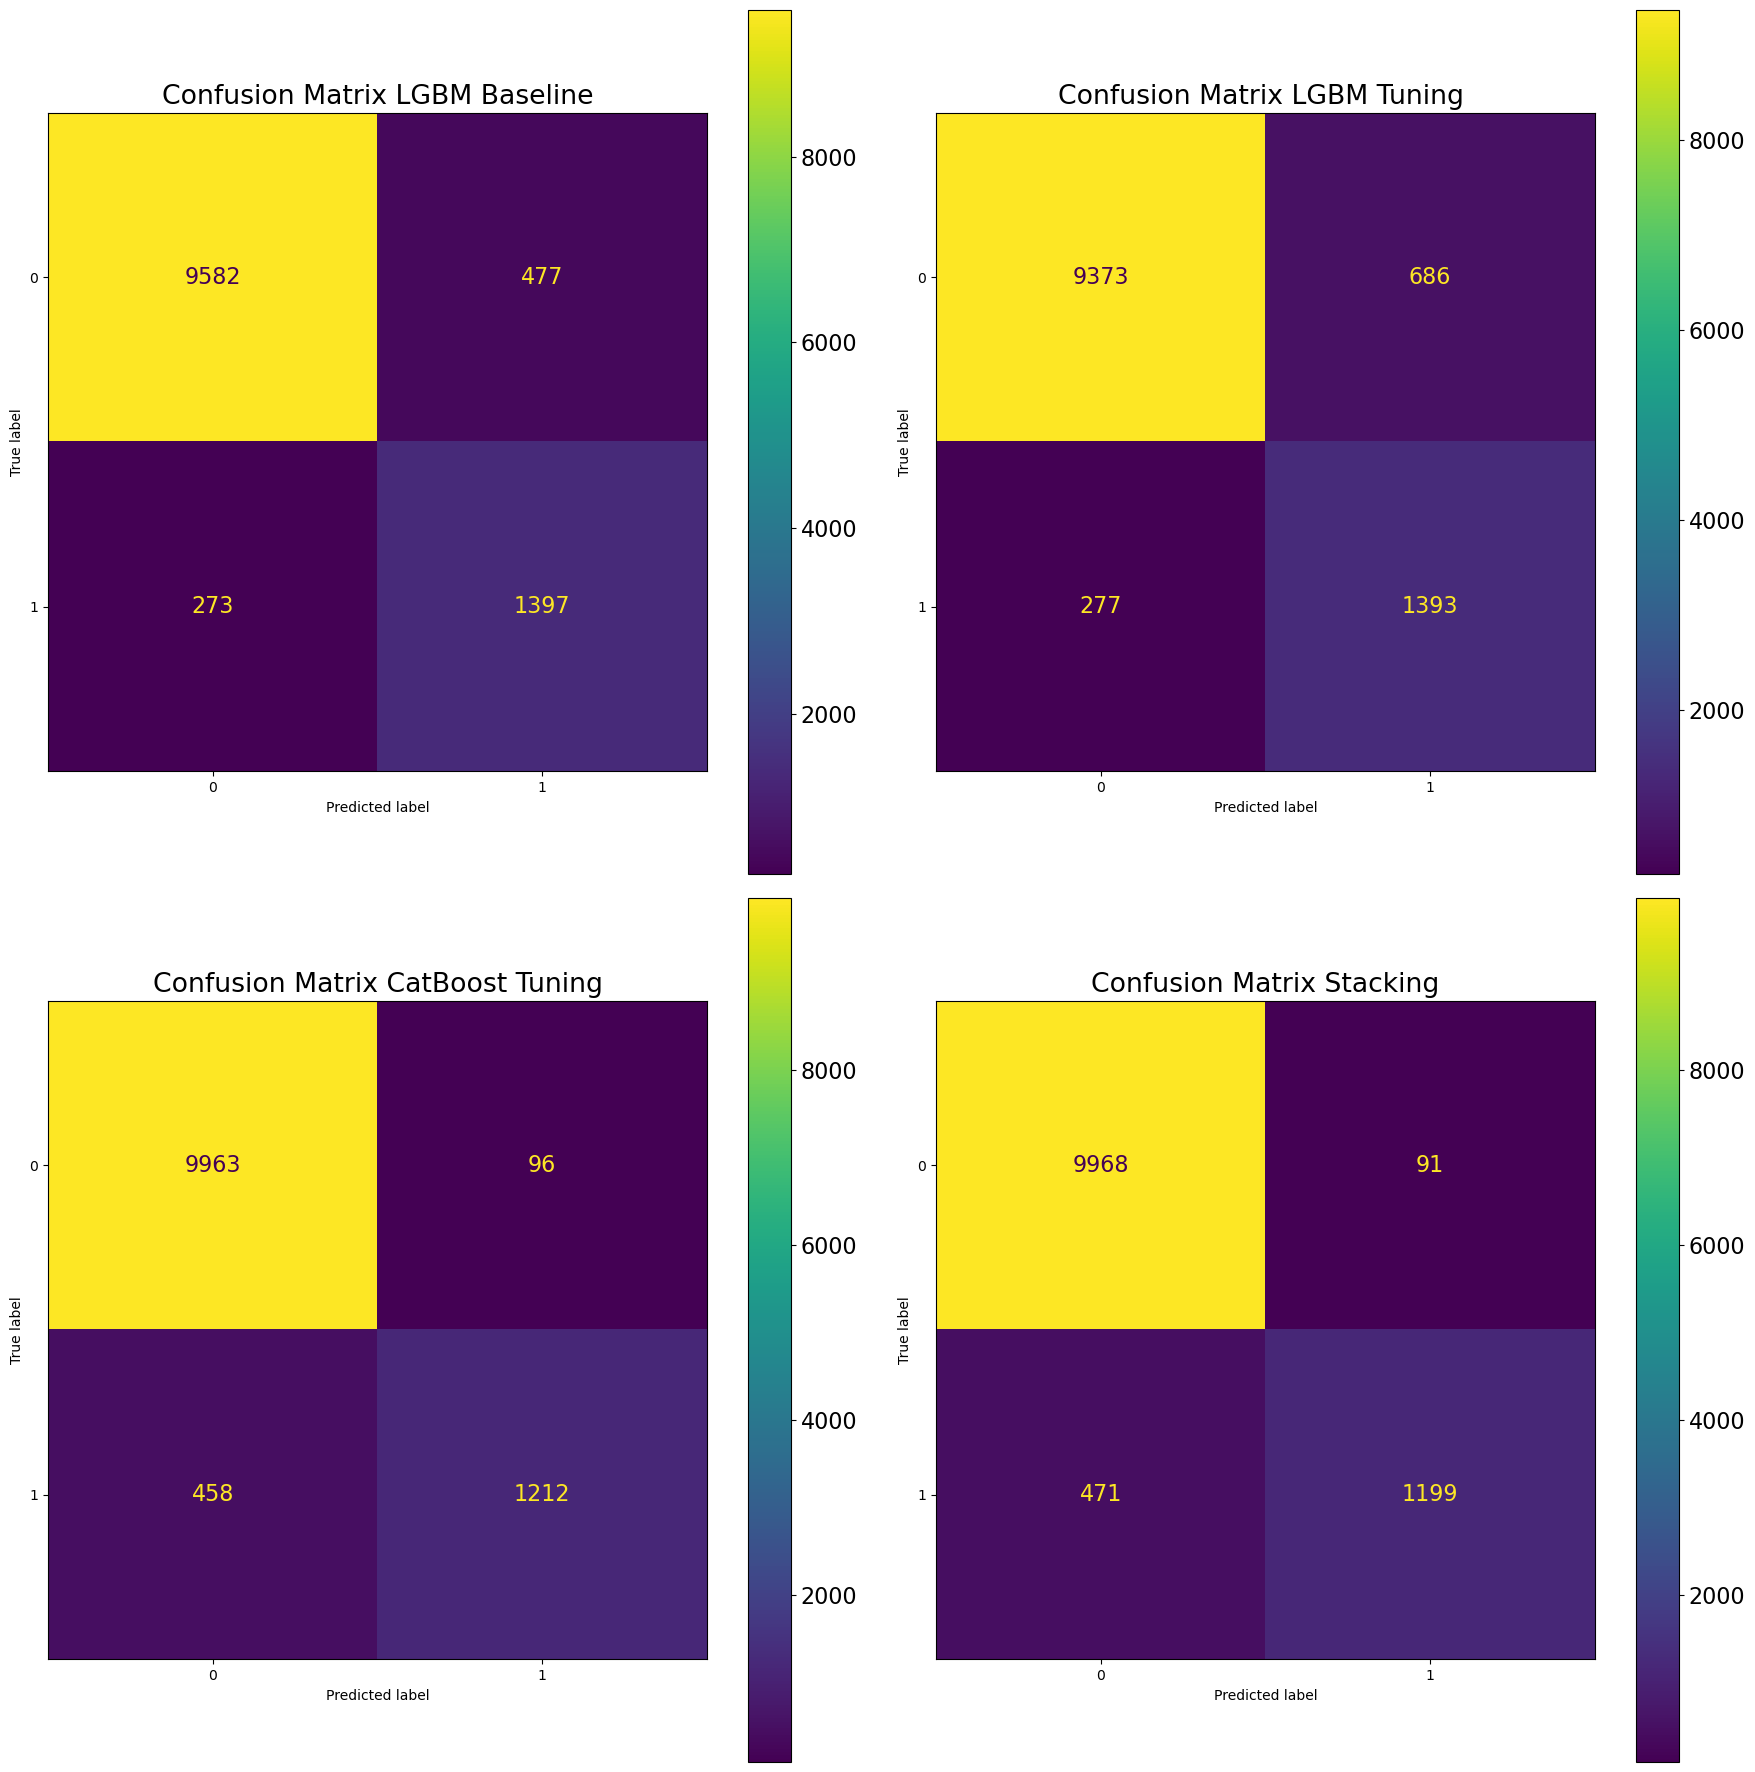

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=lgb, y_true=y_test, X=X_test, ax=ax[0][0])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=clf, y_true=y_test, X=X_test, ax=ax[0][1])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=cat_grid, y_true=y_test, X=X_test, ax=ax[1][0])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=meta, y_true=y_test, X=X_test, ax=ax[1][1])

ax[0][0].set_title('Confusion Matrix LGBM Baseline')
ax[0][1].set_title('Confusion Matrix LGBM Tuning ')
ax[1][0].set_title('Confusion Matrix CatBoost Tuning')
ax[1][1].set_title('Confusion Matrix Stacking')
plt.tight_layout()  
plt.show()

После применения стекинга удалось улучшить метрики, а также уменьшить количество FP. При этом незначительно вырос процент переобучения.

In [121]:
# Сохраняем модель
model_path = training['model_path']
joblib.dump(meta, model_path)

['../models/model_stacking.joblib']

In [127]:
save_metrics = metrics.reset_index(drop=True, inplace=True)
save_metrics

In [131]:
# Сохраняем метрики
metrics_path = training['metrics_path']

save_metrics = metrics.to_json()
with open(metrics_path, 'w') as f:
    json.dump(save_metrics, f)